# Pareto Frontiers for Toggling, Adjoint, and Universal Robustness Objectives (Robustness & Fidelity Trade-off)


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [2]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

### Pareto Frontiers + Penalty Plots

In [3]:
n_guesses = 3
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []
n_seeds = n_guesses


for i in 1:n_seeds
    Random.seed!(1234+i)
    a_bounds = fill(1.0, n_drives)
    da_bounds = fill(1.0, n_drives)
    # da_bounds = fill((5.5+0.5*i)*π*Δt/T, n_drives)
    dda_bounds = fill(10^(1.0-i), n_drives)
    control_bounds = (a_bounds, da_bounds, dda_bounds)
    traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(seeds, traj)
end



In [4]:
a_vals = exp.(range(log(100), log(100000), length=8))
final_fid_floor_log = 1 .- 1 ./ a_vals
final_fid_floor = final_fid_floor_log

n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

init_def_fids = zeros(n_seeds, n_nines)
init_var_fids = zeros(n_seeds, n_nines)
init_tog_fids = zeros(n_seeds, n_nines)
init_uni_fids = zeros(n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for j in 1:n_nines
        Random.seed!(1234+i)
        # default case (no robustness)
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        # variational objective
        var_prob = UnitaryVariationalProblem(var_sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), robust_times=[[T], [T], [T]], Q_r=0.1, piccolo_options=piccolo_opts)
        init_var_probs[i, j] = var_prob
        var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
        init_var_fids[i,j] = var_fid

        # toggling objective
        tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_rob_loss=true, H_err=Hₑ_add, Q_t=0.1)
        init_tog_probs[i, j] = tog_prob
        tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
        init_tog_fids[i,j] = tog_fid

        # universal objective
        uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_hyperspeed=true)
        init_uni_probs[i, j] = uni_prob
        uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
        init_uni_fids[i,j] = uni_fid

    end
end

for i in 1:n_seeds
    for j in 1:n_nines
        
        takes = 1
        while takes < 130 && init_var_fids[i,j] < final_fid_floor[j]
            solve!(init_var_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
            init_var_fids[i,j] = init_var_fid
            takes += 1
        end
        
        takes = 1
        while takes < 130 && init_tog_fids[i,j] < final_fid_floor[j]
            solve!(init_tog_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
            init_tog_fids[i,j] = init_tog_fid
            takes += 1
        end

        takes = 1
        while takes < 130 && init_uni_fids[i,j] < final_fid_floor[j]
            solve!(init_uni_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
            init_uni_fids[i,j] = init_uni_fid
            takes += 1
        end

        takes = 1
        while takes < 130 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=4, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

    end
end



    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using i

Excessive output truncated after 524298 bytes.

    initializing optimizer...
        applying constraint: timesteps all equal constraint

Initial Fidelity Summary Table

In [5]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(init_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(init_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(init_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999984 |     0.995588 |      0.998936 |      0.990047 |"

"0.996272 |     0.999984 |     0.996802 |      0.998936 |      0.999739 |"

"0.998611 |     0.999984 |     0.999263 |      0.998936 |      0.999739 |"

"0.999482 |     0.999984 |     0.999532 |      0.999999 |      0.999739 |"

"0.999807 |     0.999984 |      0.99983 |      0.999999 |      0.999845 |"

"0.999928 |     0.999984 |     0.999958 |      0.999999 |      0.999999 |"

"0.999973 |     0.999984 |     0.996363 |      0.999999 |      0.999999 |"

"0.99999 |     0.999999 |     0.996363 |      0.999999 |      0.999999 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.997961 |     0.992878 |      0.995597 |      0.999883 |"

"0.996272 |     0.997961 |     0.993994 |      0.999999 |      0.999883 |"

"0.998611 |     0.999814 |     0.993994 |      0.999999 |      0.999883 |"

"0.999482 |     0.999814 |     0.993994 |      0.999999 |      0.999883 |"

"0.999807 |     0.999814 |     0.993994 |      0.999999 |      0.999883 |"

"0.999928 |     0.999981 |     0.993994 |      0.999999 |      0.999996 |"

"0.999973 |     0.999981 |     0.993994 |      0.999999 |      0.999996 |"

"0.99999 |     0.999998 |     0.993994 |      0.999999 |      0.999996 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.995698 |     0.004851 |      0.997962 |      0.998512 |"

"0.996272 |     0.999784 |     0.004851 |      0.997962 |      0.998512 |"

"0.998611 |     0.999784 |     0.004851 |      0.999514 |      0.999884 |"

"0.999482 |     0.999784 |     0.004851 |      0.999514 |      0.999884 |"

"0.999807 |     0.999998 |     0.004851 |      0.999997 |      0.999884 |"

"0.999928 |     0.999998 |     0.004851 |      0.999997 |      0.999985 |"

"0.999973 |     0.999998 |     0.004851 |      0.999997 |      0.999985 |"

"0.99999 |     0.999998 |     0.004851 |      0.999997 |      0.914549 |"

Solve Max-Toggle Problems

In [6]:
n_nines = length(final_fid_floor)
final_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]

for i in 1:n_seeds
    for j in 1:n_nines

        var_prob = UnitaryVariationalProblem(
                var_sys,  U_goal, T, Δt;
                robust_times=[[T], [T], [T]],
                Q=0.0,
                Q_r=1.0,
                init_trajectory=init_var_probs[i,j].trajectory,
                var_seed=false,
                piccolo_options=piccolo_opts
            )
        F = final_fid_floor[j]
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        solve!(var_prob, max_iter=40, print_level=5)
        final_var_probs[i,j] = var_prob

        tog_prob = UnitaryMaxToggleProblem(
                init_tog_probs[i,j],
                U_goal,
                Hₑ_add;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(tog_prob, max_iter=40, print_level=5)
        final_tog_probs[i,j] = tog_prob

        uni_prob = UnitaryMaxUniversalProblem(
                init_uni_probs[i,j],
                U_goal;
                Q_t=1.0,
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(uni_prob, max_iter=40, print_level=5)
        final_uni_probs[i,j] = uni_prob


        # X_drive = sys.H.H_drives[1]
        # Hₑ_mult = a -> a[1] * X_drive

        # mult_prob = UnitaryMaxToggleProblem(
        #         warm_mult_probs[i,j],
        #         U_goal,
        #         Hₑ_mult;
        #         Q_t=1.0,
        #         final_fidelity=final_fid_floor[j],
        #         piccolo_options=piccolo_opts
        #     )
        # solve!(mult_prob, max_iter=75, print_level=5)
        # final_mult_probs[i,j] = mult_prob

        
        # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
        # both_prob = UnitaryToggleProblem(
        #     sys, U_goal, T, Δt, Hₑ_both;
        #     piccolo_options=piccolo_opts
        #     )
        # solve!(both_prob, max_iter=150, print_level=5)

    end
end



Pareto Frontiers

In [9]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end


space_curve_robustness (generic function with 1 method)

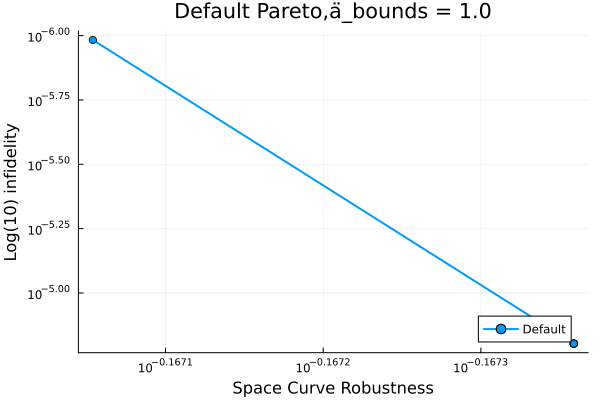

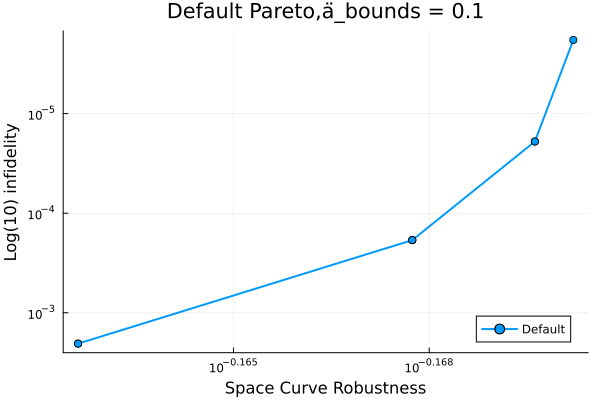

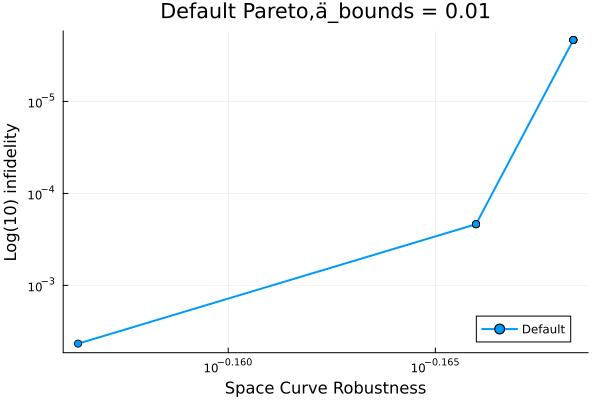

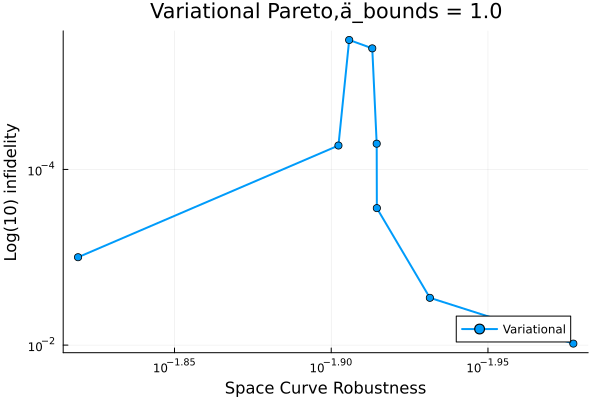

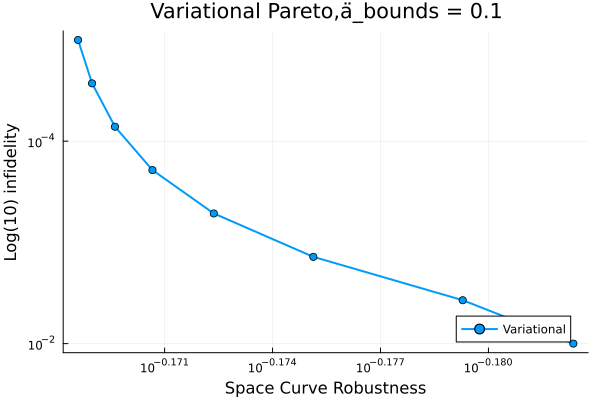

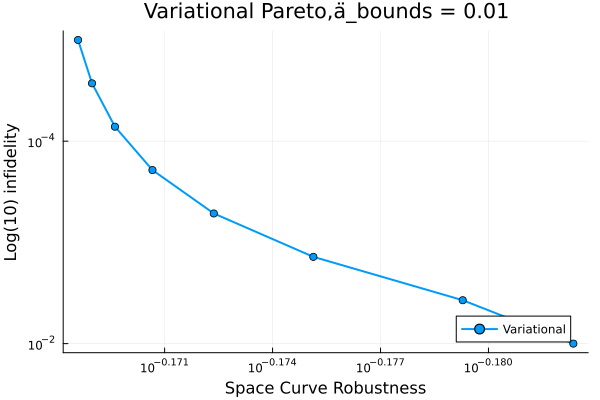

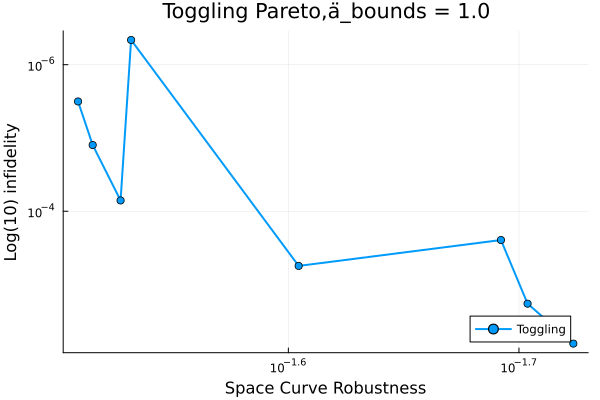

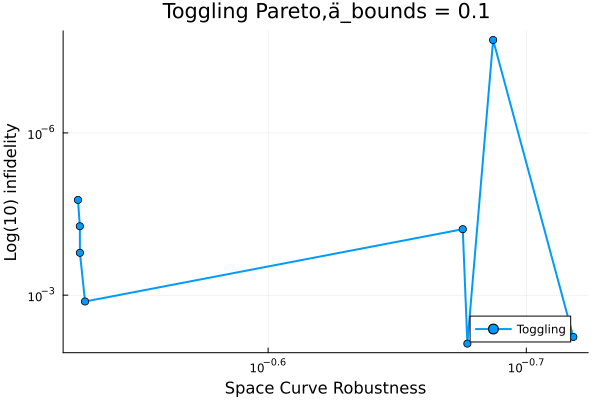

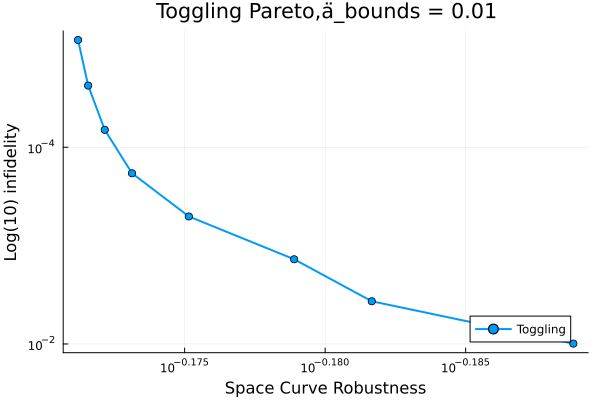

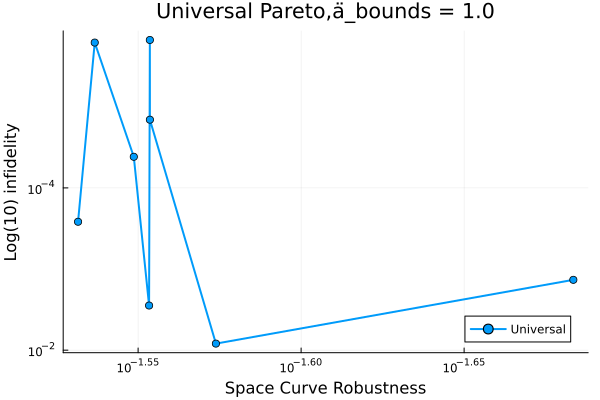

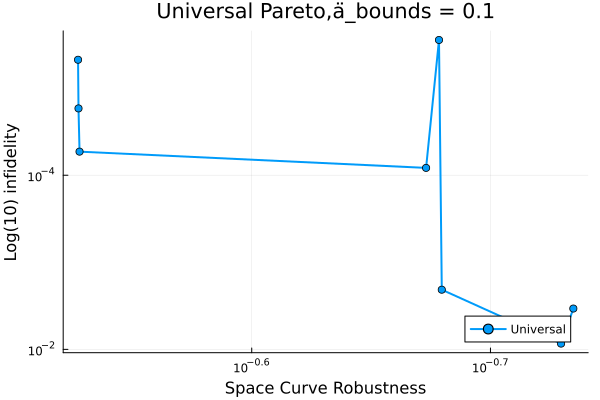

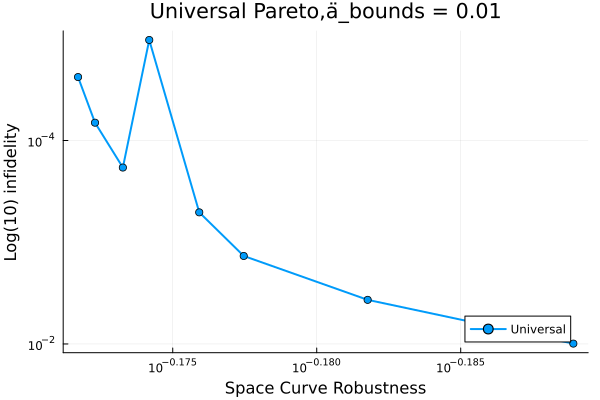

In [10]:
arr_probs = [default_probs, final_var_probs, final_tog_probs, final_uni_probs]
method_names = ["Default", "Variational", "Toggling", "Universal"]


for (prob_idx, probs) in enumerate(arr_probs)
    method_name = method_names[prob_idx]

    
    for s in 1:n_seeds
        dda = round(10^(1.0-s); digits=2)
        plt = Plots.plot(
            xlabel="Space Curve Robustness",
            ylabel="Log(10) infidelity",
            title="$method_name Pareto,ä_bounds = $dda",
            xscale = :log10, yscale = :log10,
            legend=:bottomright, grid=true,
            xflip=true,
            yflip=true
        )
        
        xs = Float64[]  # robustness from space curve
        ys = Float64[]  # infidelity
        
        for (j, f) in enumerate(final_fid_floor)
            prob = probs[s, j]
            
            # Compute robustness using space curve
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            infidelity = 1 - unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(xs, avg_robustness)
            push!(ys, infidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(xs)
        Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=method_name, linewidth=2)
        display(plt)
    end
end


In [11]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(final_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(final_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(final_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999984 |     0.990385 |      0.993601 |      0.991691 |"

"0.996272 |     0.999984 |     0.997105 |      0.998175 |      0.997181 |"

"0.998611 |     0.999984 |     0.999002 |      0.999443 |      0.998641 |"

"0.999482 |     0.999984 |     0.999724 |      0.999753 |      0.999739 |"

"0.999807 |     0.999984 |     0.999949 |      0.999929 |      0.999959 |"

"0.999928 |     0.999984 |     0.999947 |      0.999988 |      0.999986 |"

"0.999973 |     0.999984 |     0.999997 |      0.999997 |      0.999998 |"

"0.99999 |     0.999999 |     0.999996 |           1.0 |      0.999998 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.997961 |         0.99 |      0.992135 |      0.991405 |"

"0.996272 |     0.997961 |     0.996272 |      0.994078 |      0.997934 |"

"0.998611 |     0.999814 |     0.998611 |      0.998691 |        0.9966 |"

"0.999482 |     0.999814 |     0.999482 |       0.99994 |      0.999918 |"

"0.999807 |     0.999814 |     0.999807 |      0.999835 |      0.999997 |"

"0.999928 |     0.999981 |     0.999928 |      0.999947 |      0.999946 |"

"0.999973 |     0.999981 |     0.999973 |      0.999983 |      0.999983 |"

"0.99999 |     0.999998 |      0.99999 |           1.0 |      0.999995 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.995698 |         0.99 |      0.990079 |      0.990073 |"

"0.996272 |     0.999784 |     0.996272 |      0.996317 |      0.996314 |"

"0.998611 |     0.999784 |     0.998611 |      0.998623 |      0.998635 |"

"0.999482 |     0.999784 |     0.999482 |      0.999494 |      0.999492 |"

"0.999807 |     0.999998 |     0.999807 |      0.999816 |      0.999816 |"

"0.999928 |     0.999998 |     0.999928 |      0.999933 |      0.999933 |"

"0.999973 |     0.999998 |     0.999973 |      0.999976 |      0.999976 |"

"0.99999 |     0.999998 |      0.99999 |      0.999992 |       0.99999 |"

Penalty

In [ ]:
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=8))
n_lambdas = length(sweep_rob_loss_λ)

pen_var_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ) 

        # var problem
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            init_trajectory=deepcopy(init_var_probs[i,λ_idx].trajectory),
            piccolo_options=piccolo_opts,
            var_seed=false,
            Q_r=λ
        )
        solve!(var_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(var_prob; max_iter=40, print_level=5)
        pen_var_probs[i, λ_idx] = var_prob

        # tog problem
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=λ
        )
        solve!(tog_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(tog_prob; max_iter=40, print_level=5)
        pen_tog_probs[i, λ_idx] = tog_prob

        # uni problem
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true,
            Q_t=λ
        )
        solve!(uni_prob; max_iter=750, print_level=5, options=IpoptOptions(eval_hessian=false))
        solve!(uni_prob; max_iter=40, print_level=5)
        pen_uni_probs[i, λ_idx] = uni_prob
    end
end


### Full Plots

In [14]:
# function compute_space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
#     """Compute the average norm of the space curve over Pauli X, Y, Z"""
#     space_curve = SpaceCurve(traj, U_goal, H_err)
    
#     # Extract X, Y, Z components for each time step
#     x_components = [sc[1] for sc in space_curve]
#     y_components = [sc[2] for sc in space_curve]
#     z_components = [sc[3] for sc in space_curve]
    
#     # Compute norms for each Pauli direction
#     x_norm = norm(x_components)
#     y_norm = norm(y_components)
#     z_norm = norm(z_components)
    
#     # Return average norm
#     return (x_norm + y_norm + z_norm) / 3.0
# end

#### pareto with penalty

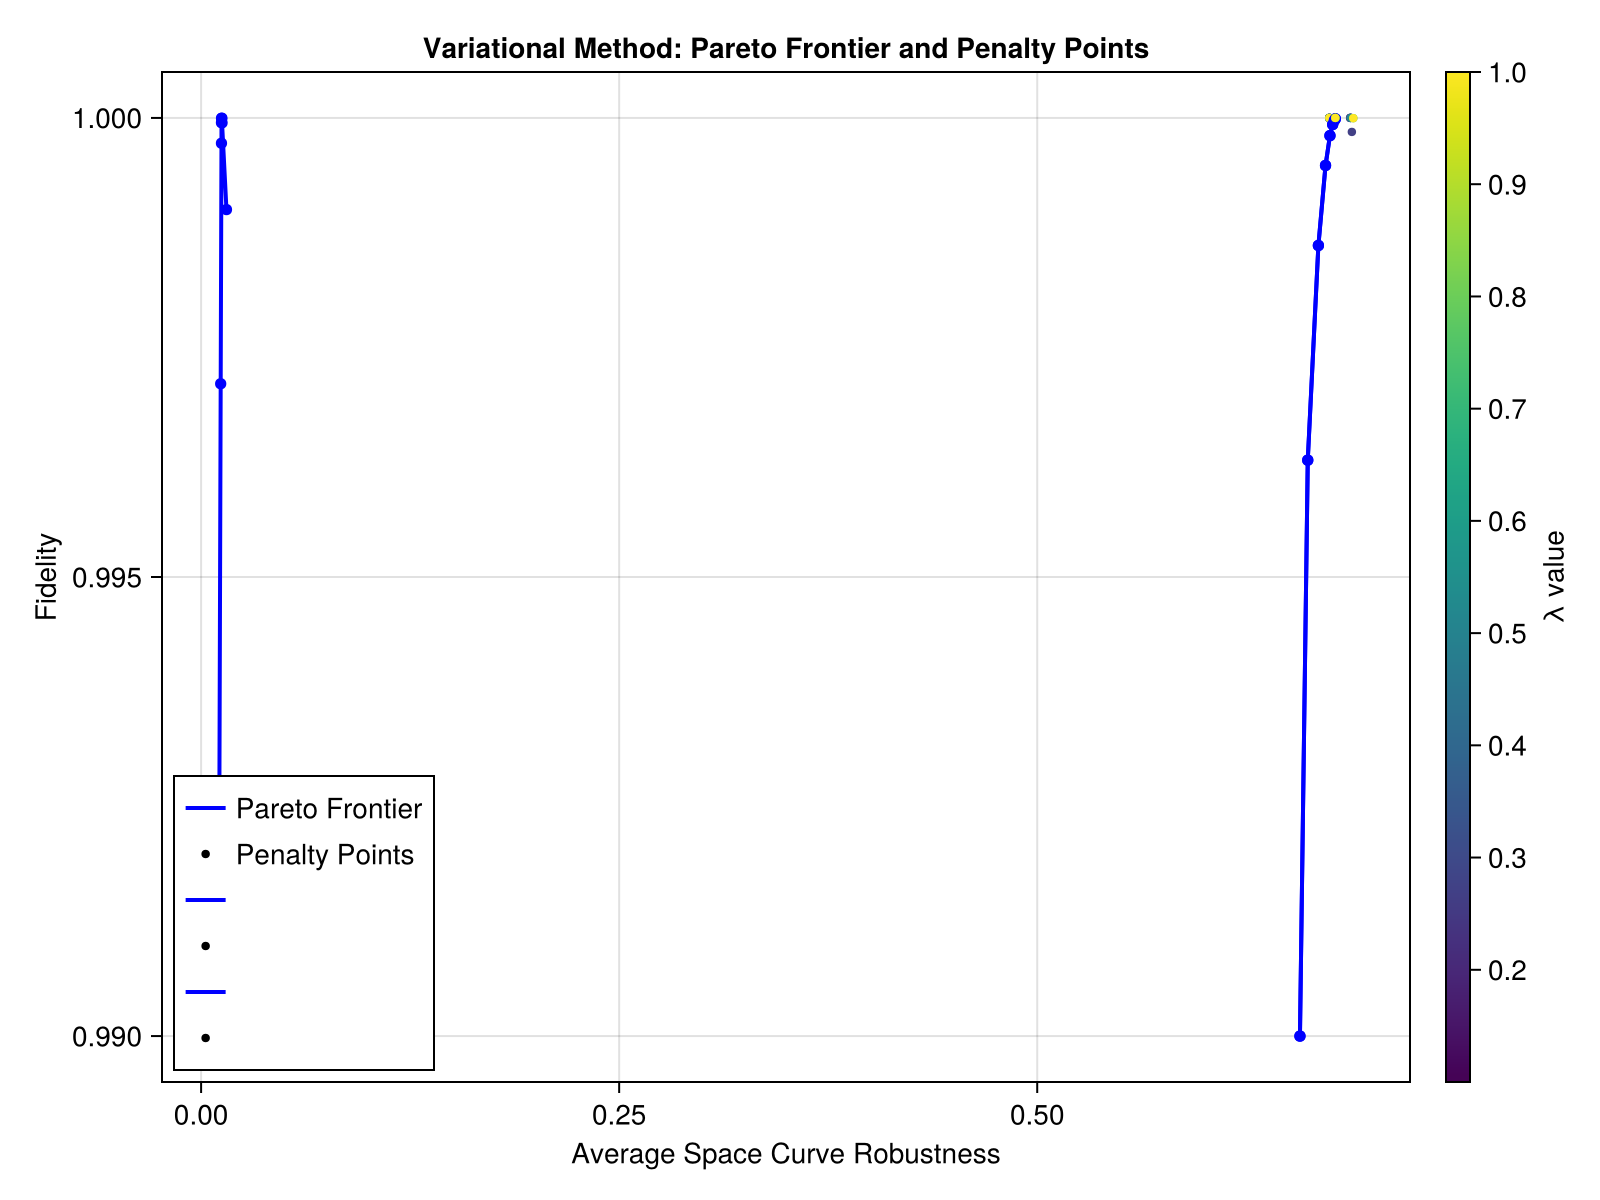

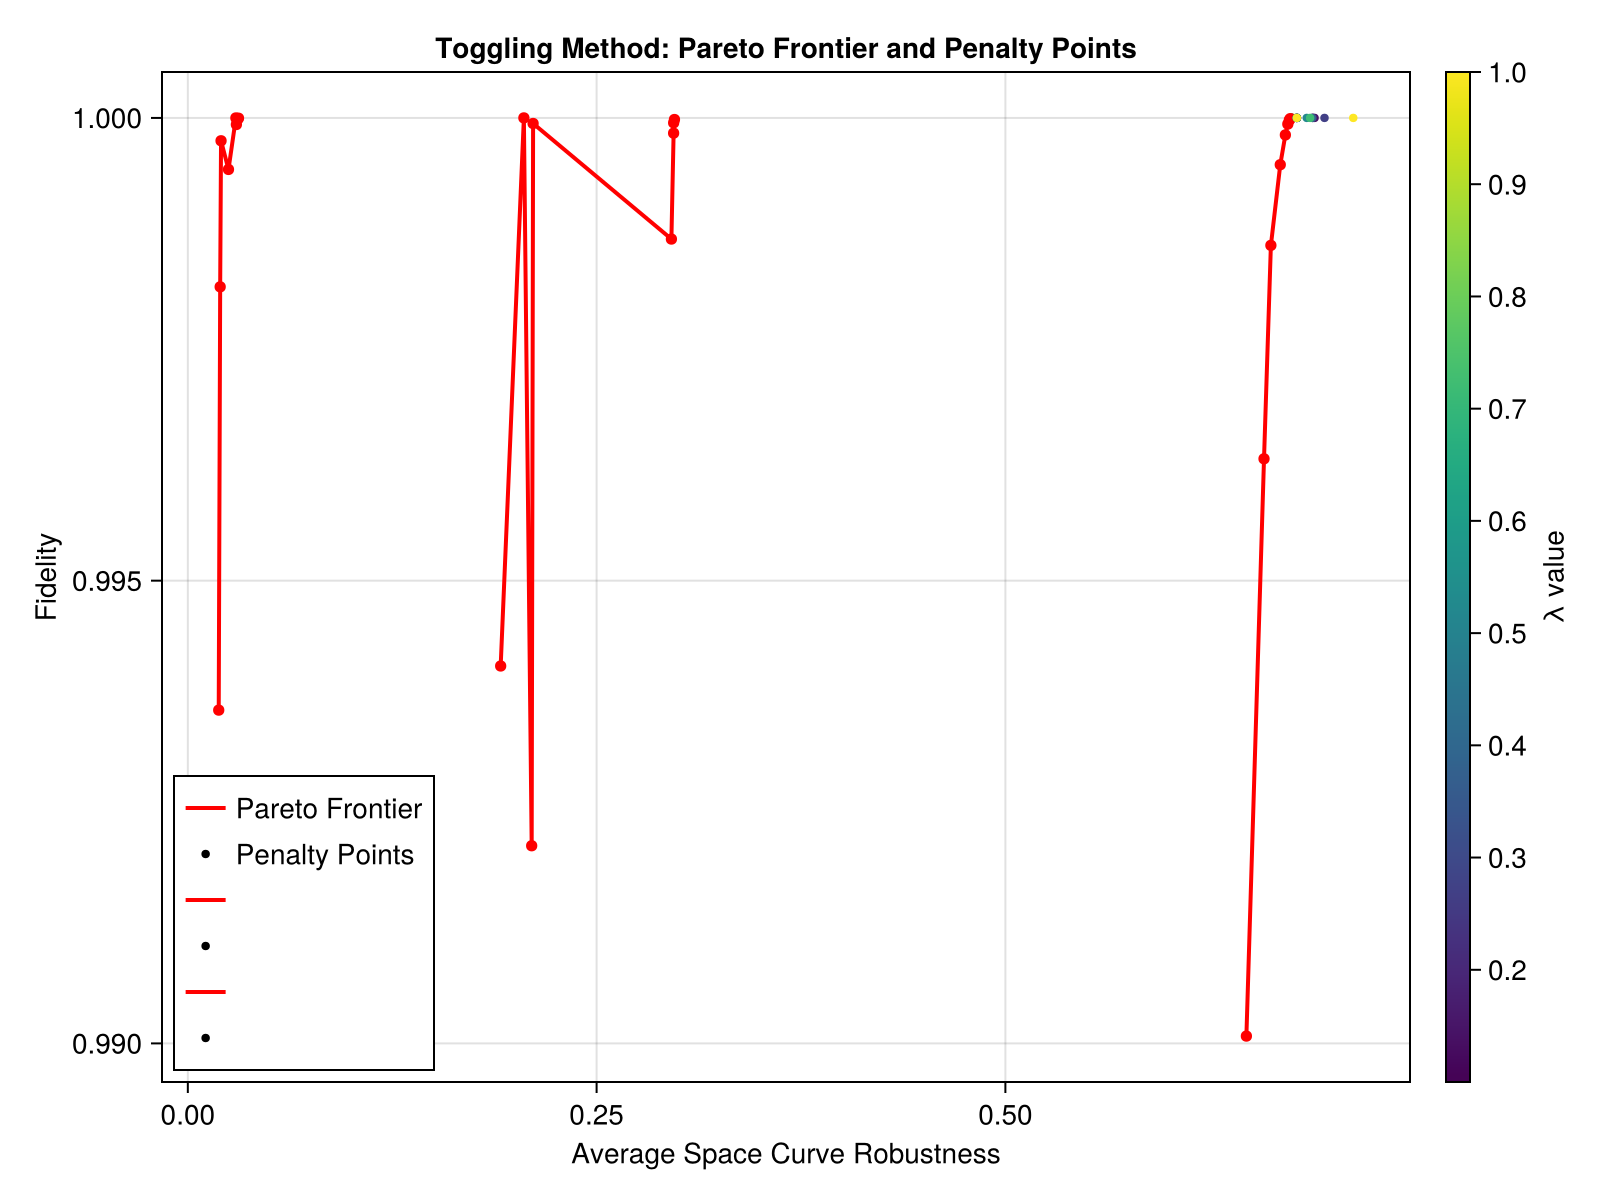

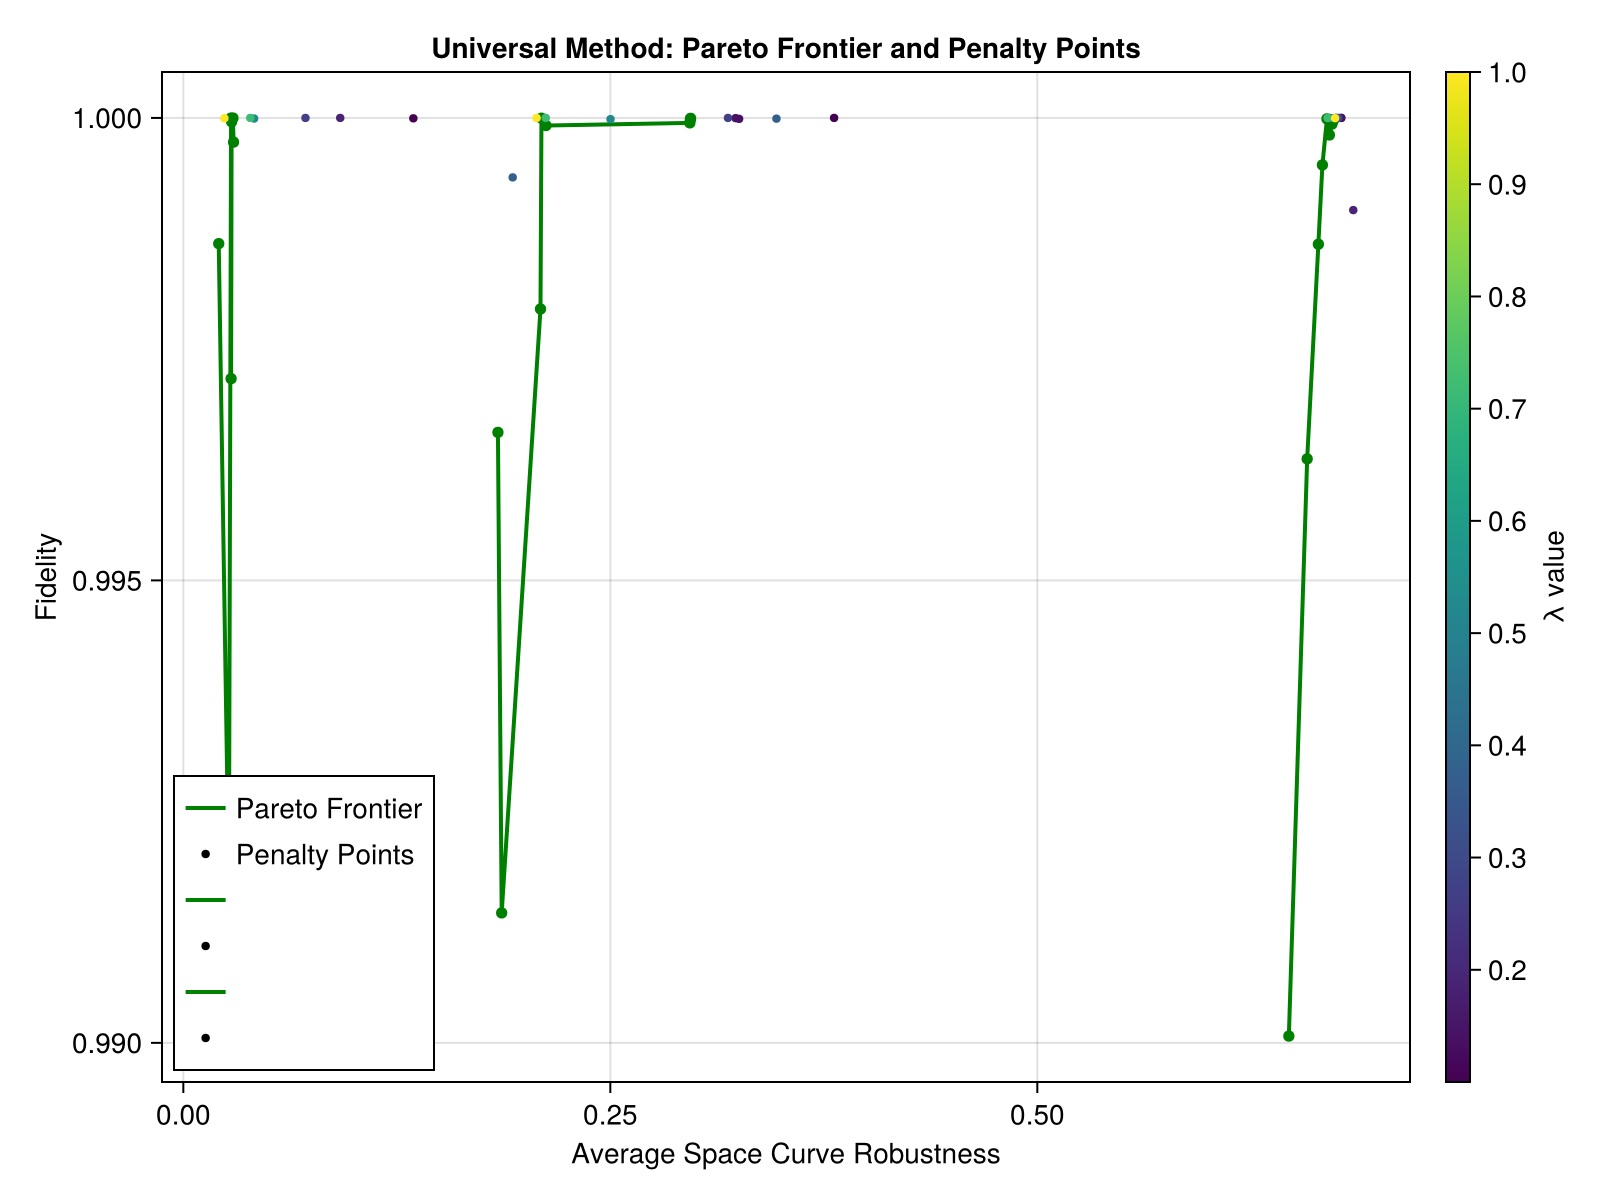

In [15]:
# Define colors for methods
method_colors = [:blue, :red, :green]
method_names_plot = ["Variational", "Toggling", "Universal"]

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    fig = Figure(resolution=(800, 600))
    ax = Axis(fig[1, 1], 
             xlabel="Average Space Curve Robustness", 
             ylabel="Fidelity",
             title="$method_name Method: Pareto Frontier and Penalty Points")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Plot for each seed
    for s in 1:n_seeds
        # Pareto frontier points
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(pareto_x, avg_robustness)
            push!(pareto_y, fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=method_colors[method_idx], linewidth=2, 
               label=s == 1 ? "Pareto Frontier" : "")
        Makie.scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=method_colors[method_idx], markersize=8)
        
        # Penalty points
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(penalty_x, avg_robustness)
            push!(penalty_y, fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        Makie.scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label=s == 1 ? "Penalty Points" : "")
    end
    
    # Add colorbar for lambda values
    Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
             colormap=:viridis, label="λ value")
    
    axislegend(ax, position=:lb)
    display(fig)
end



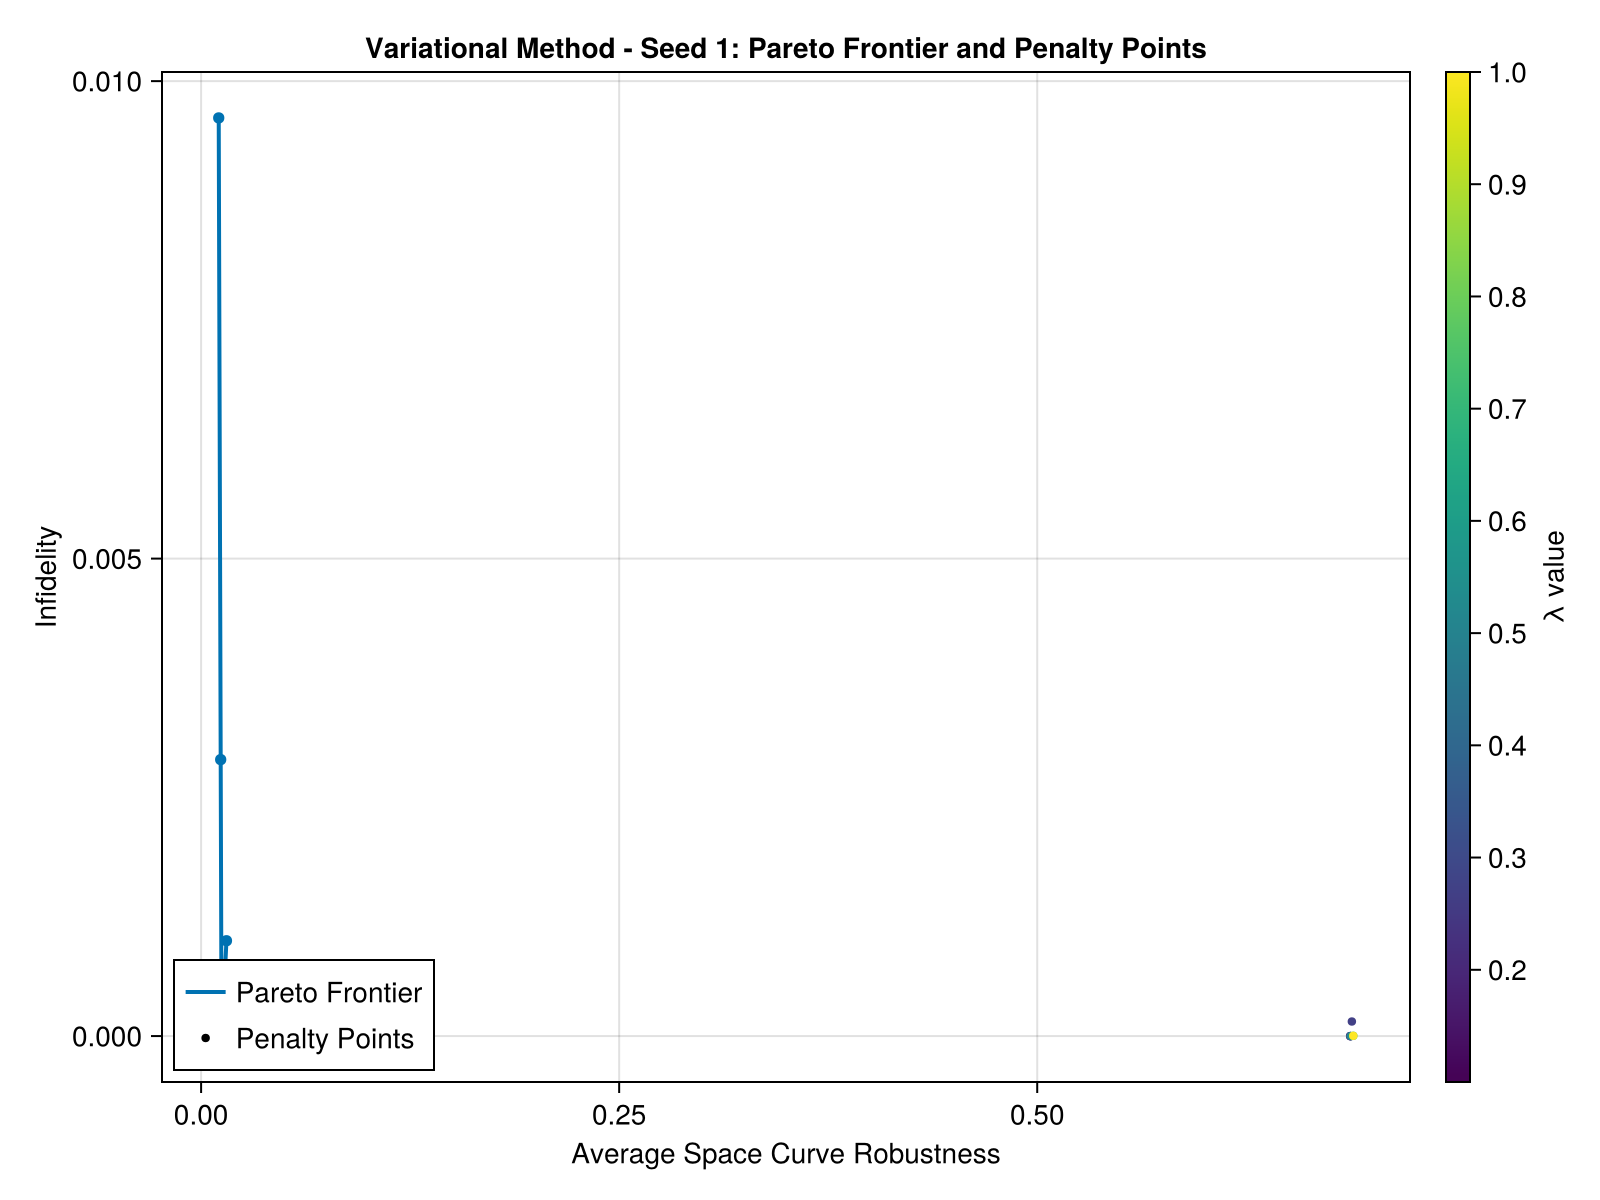

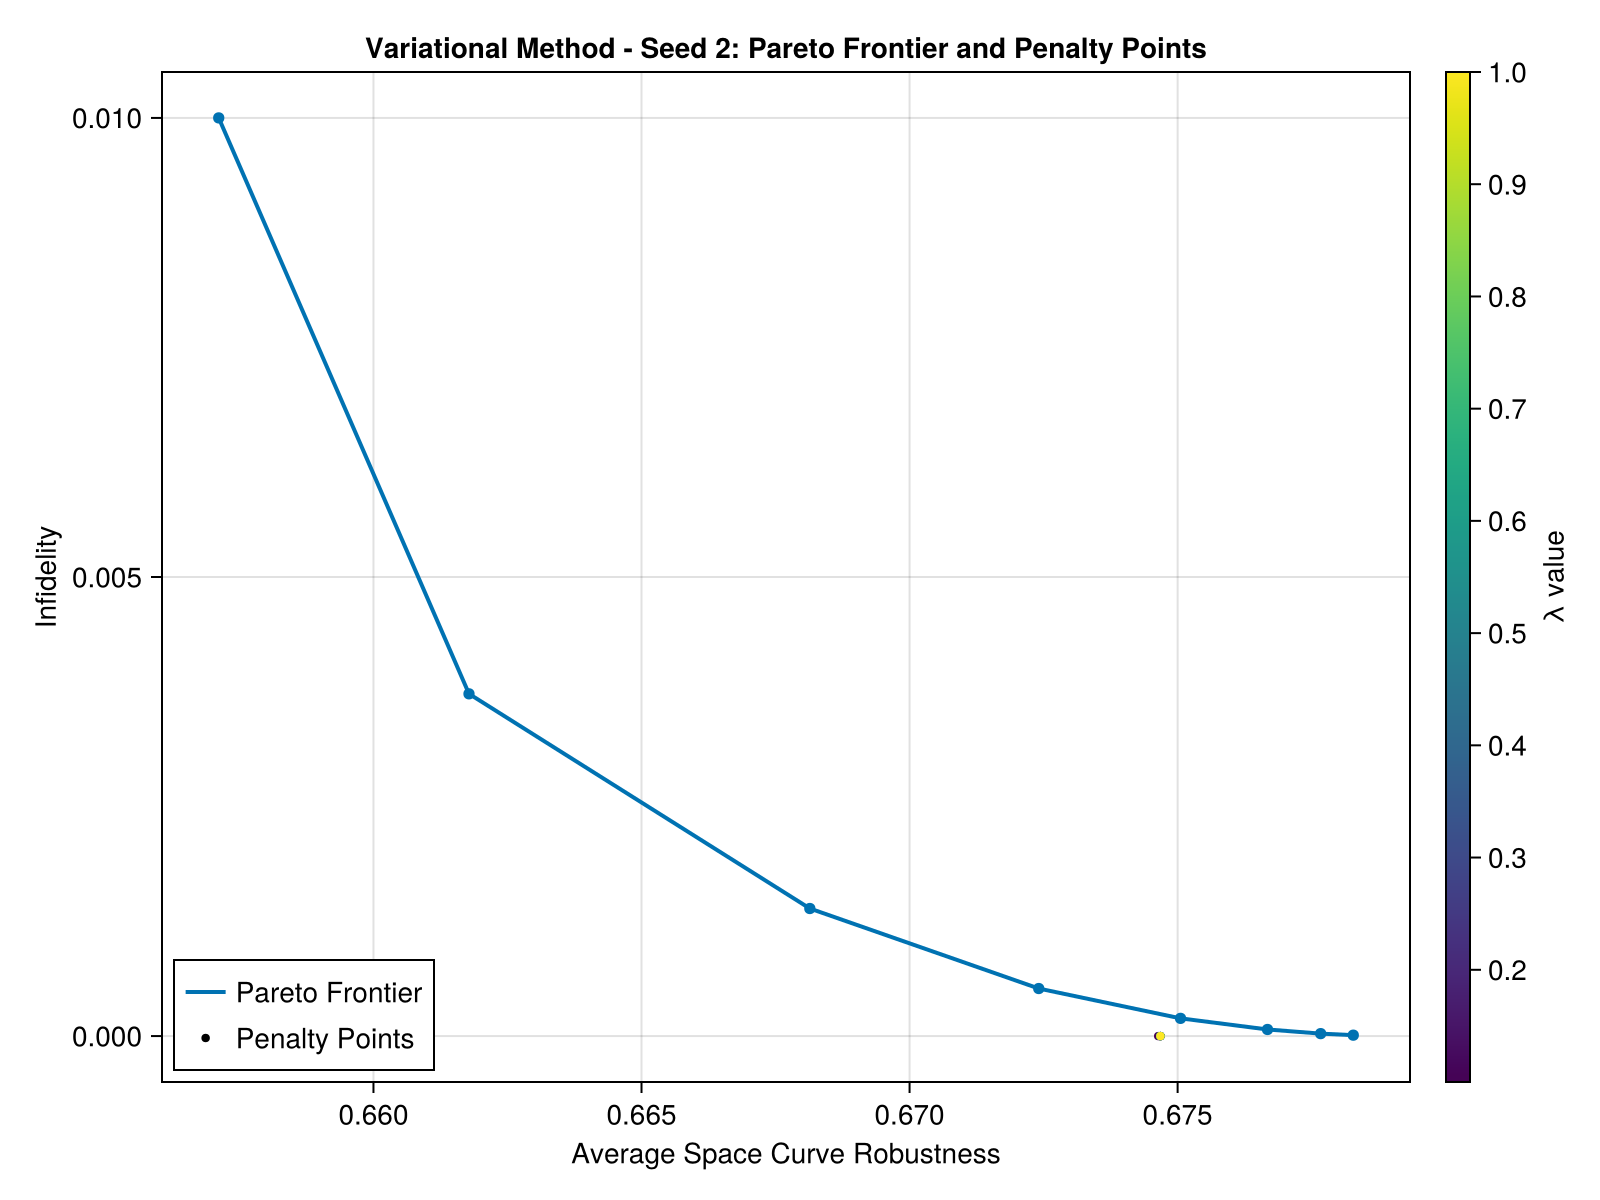

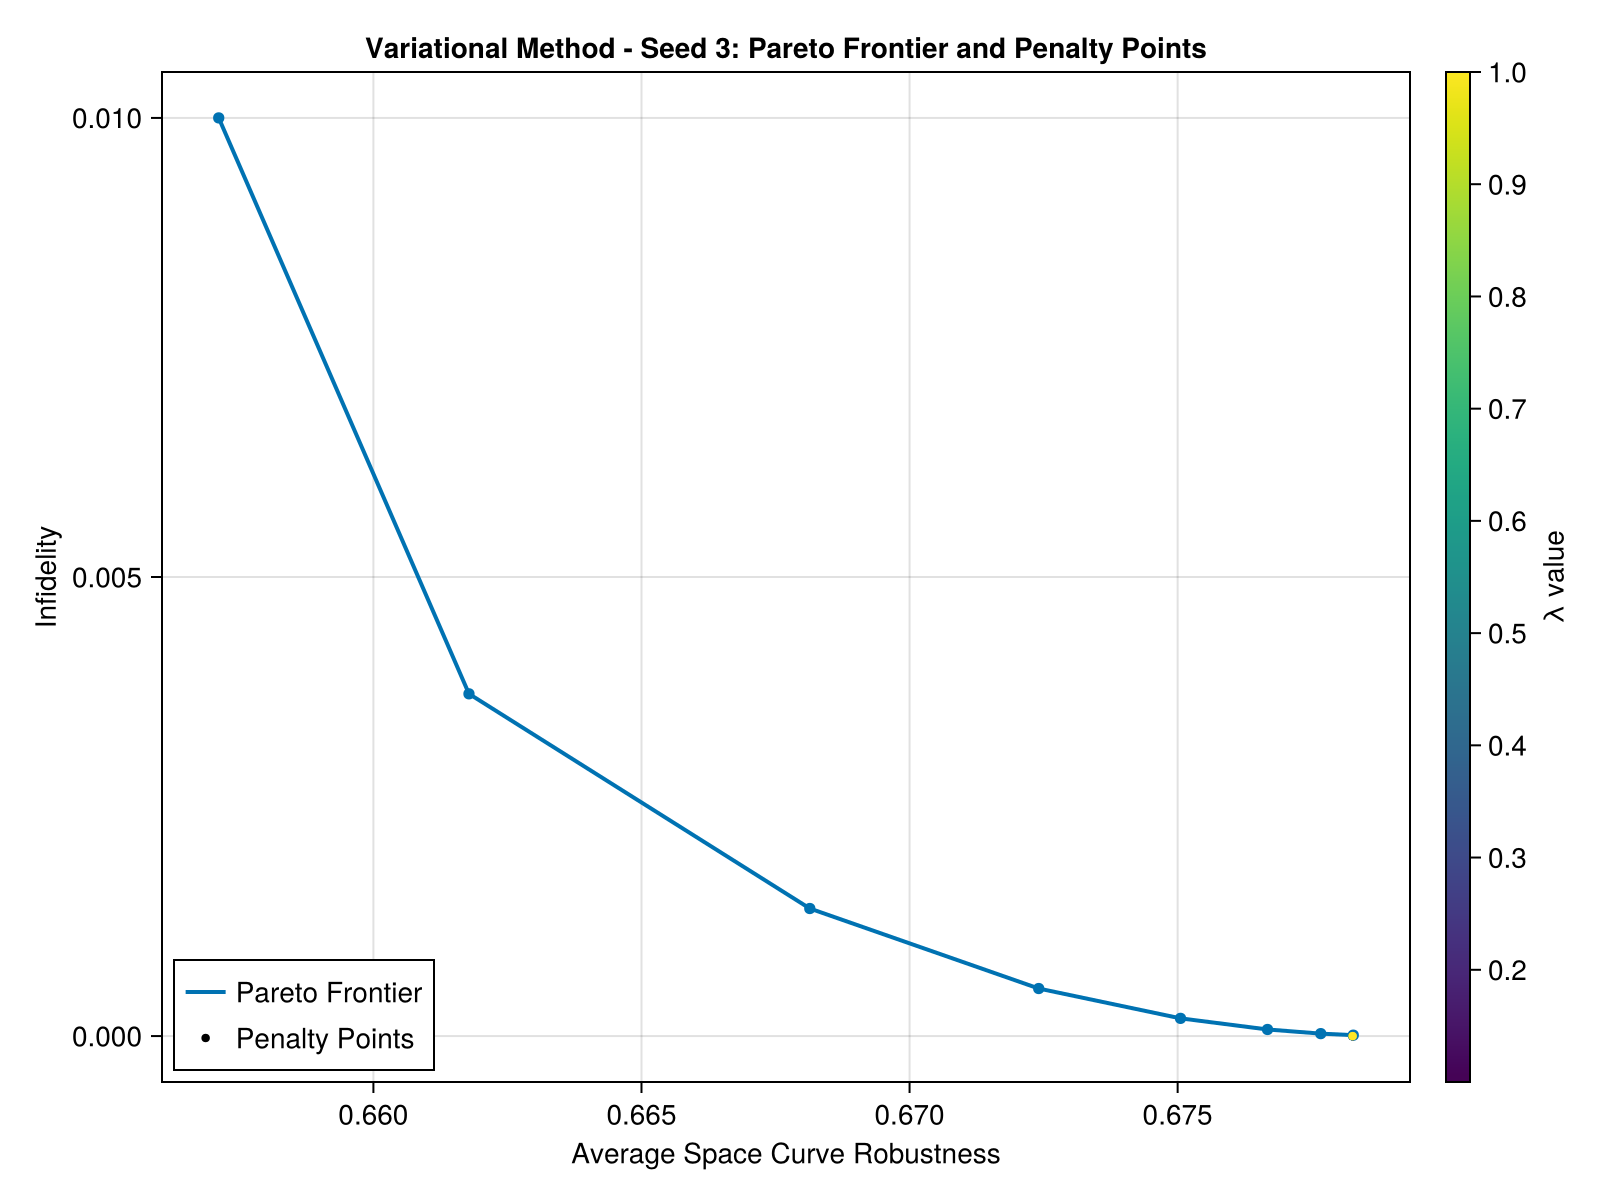

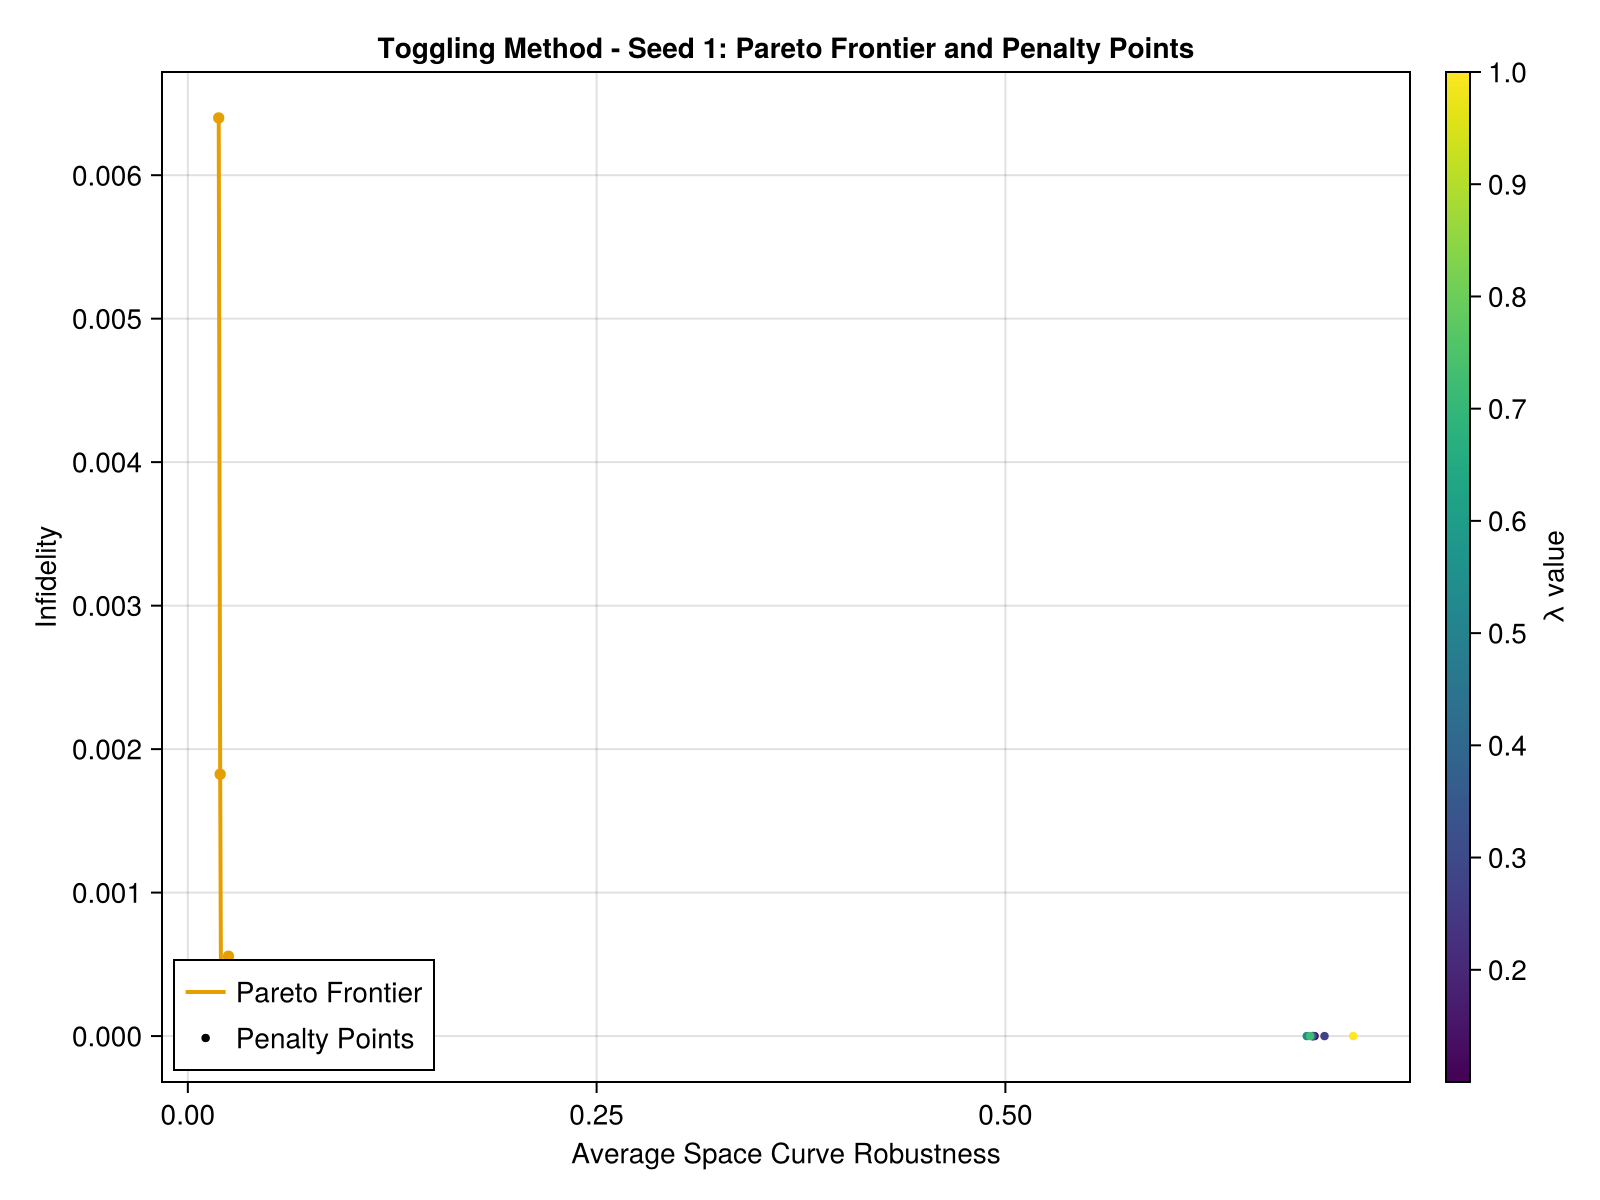

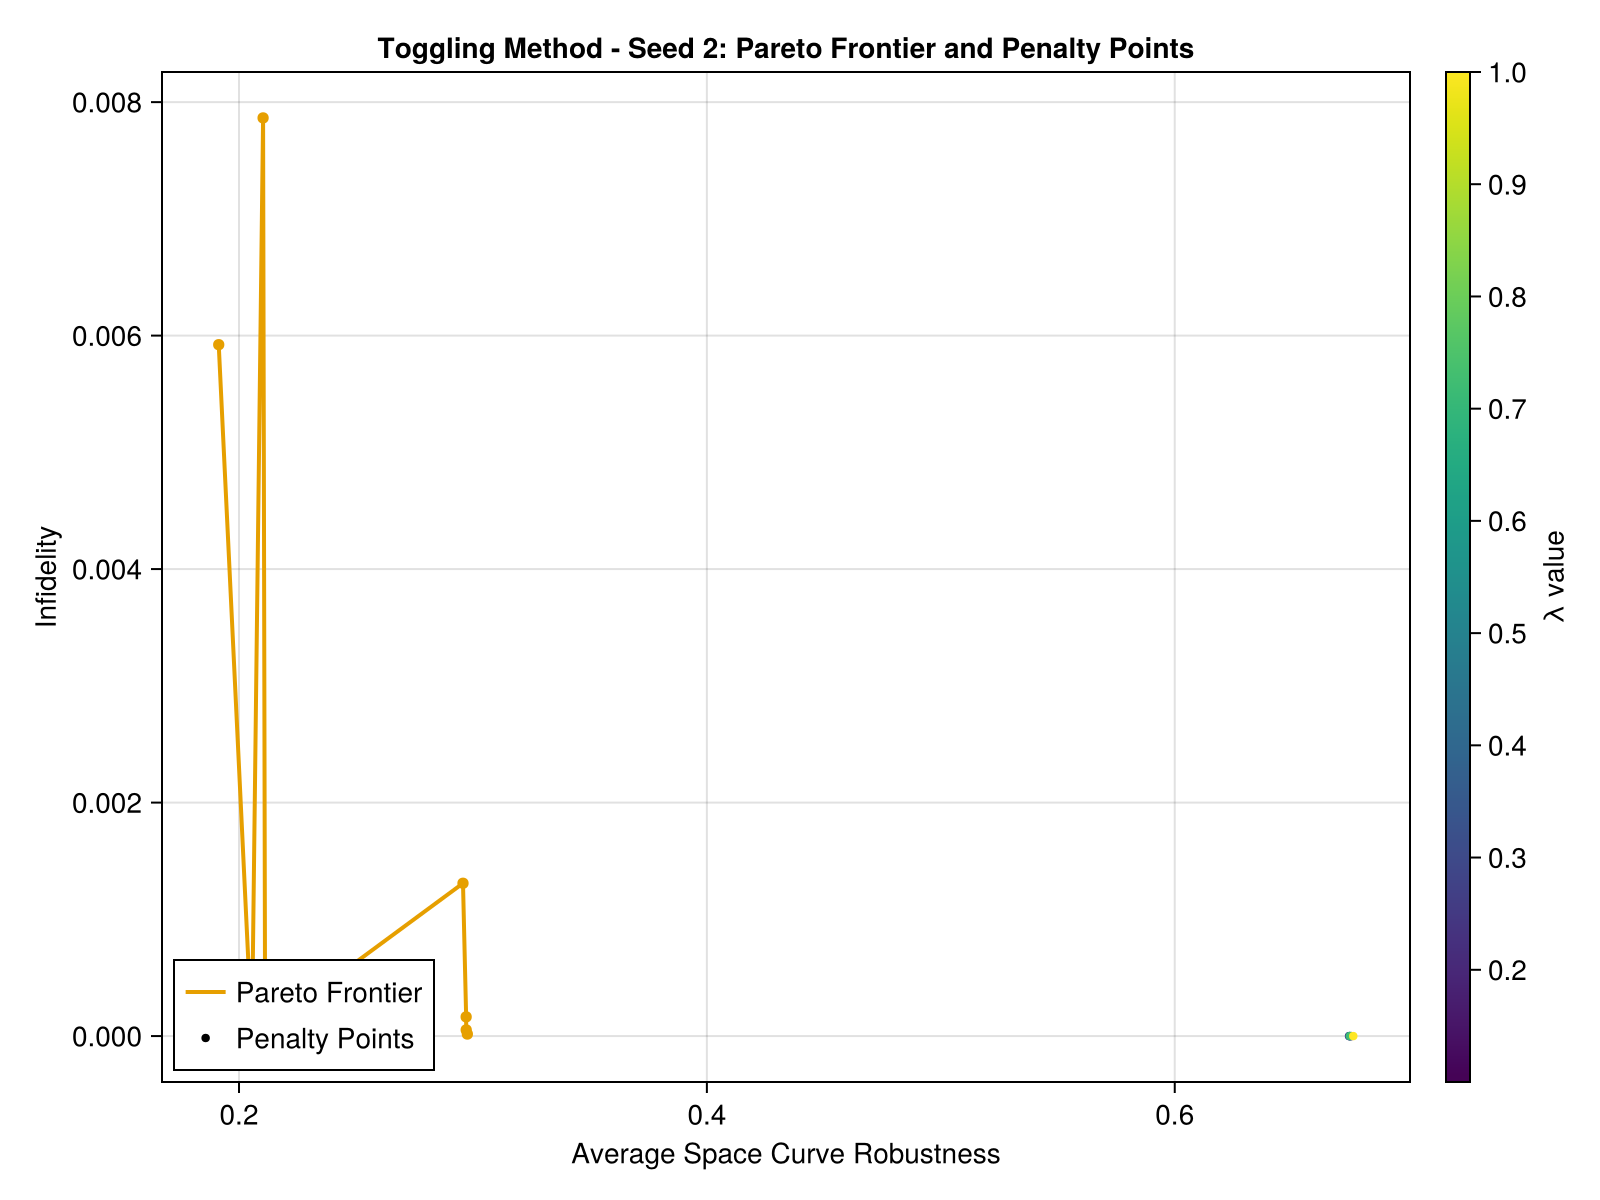

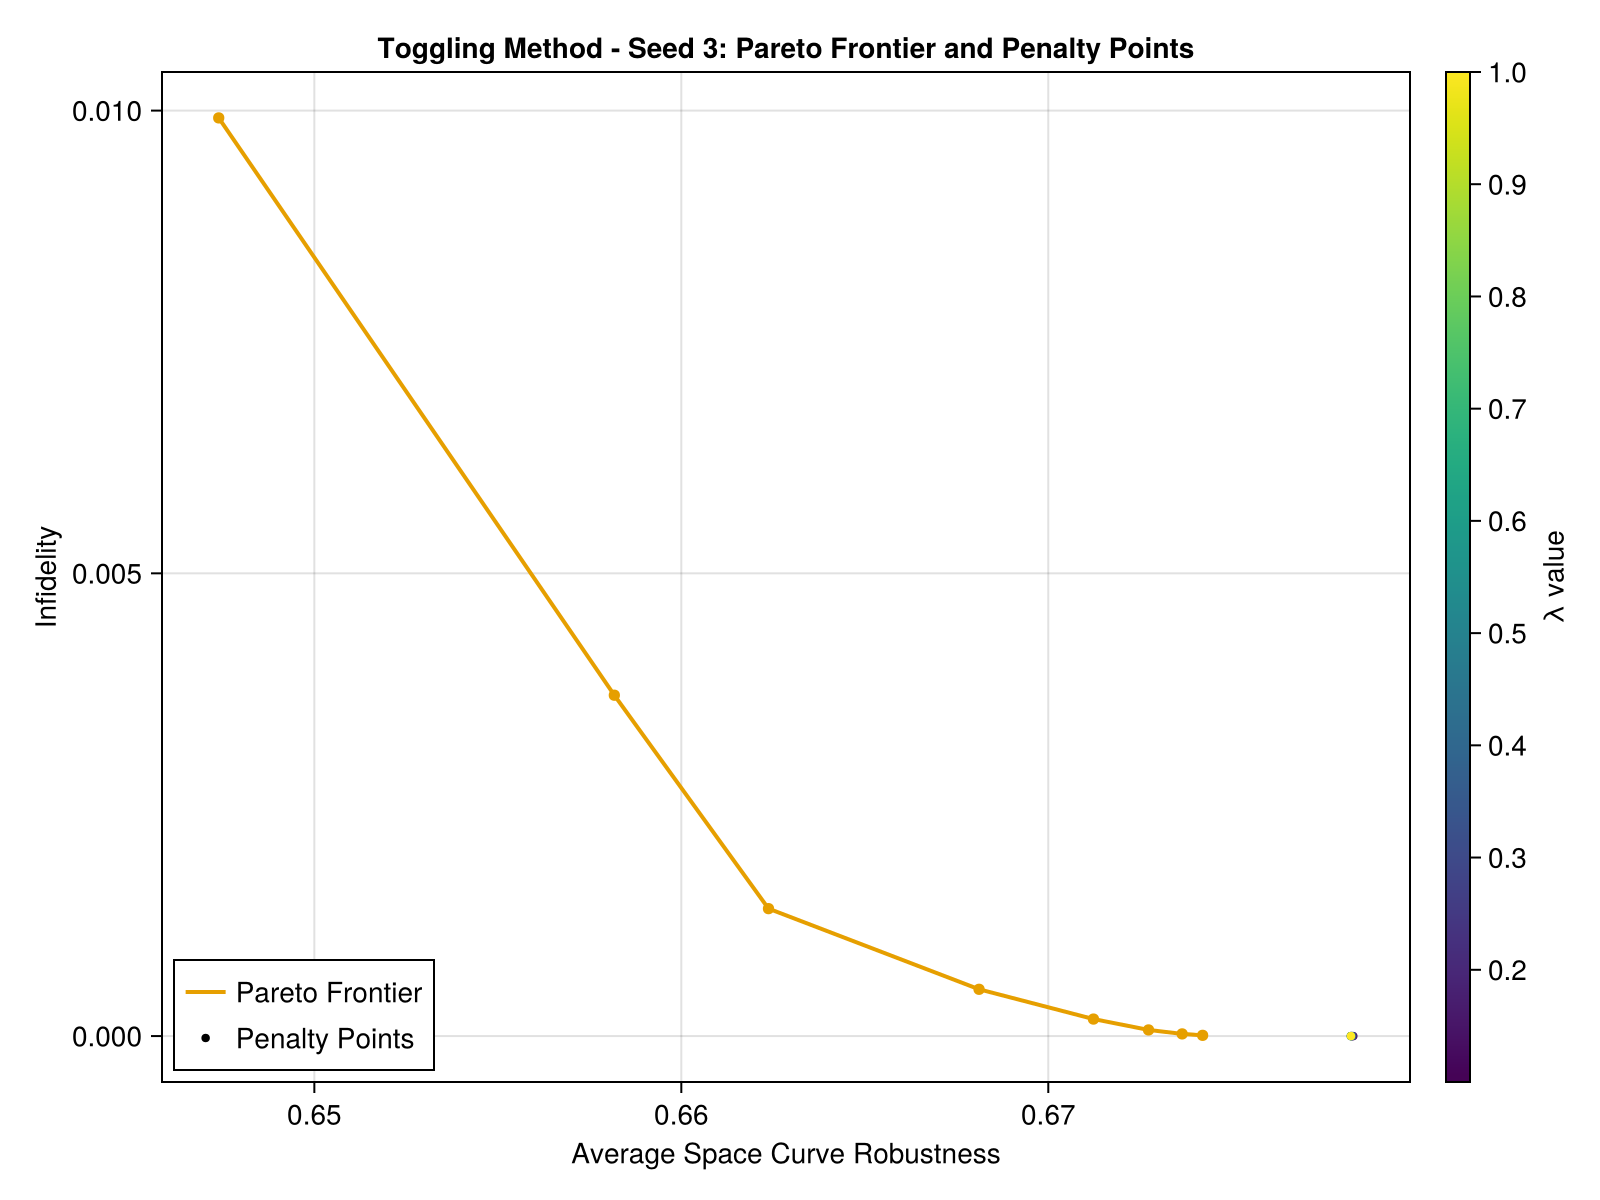

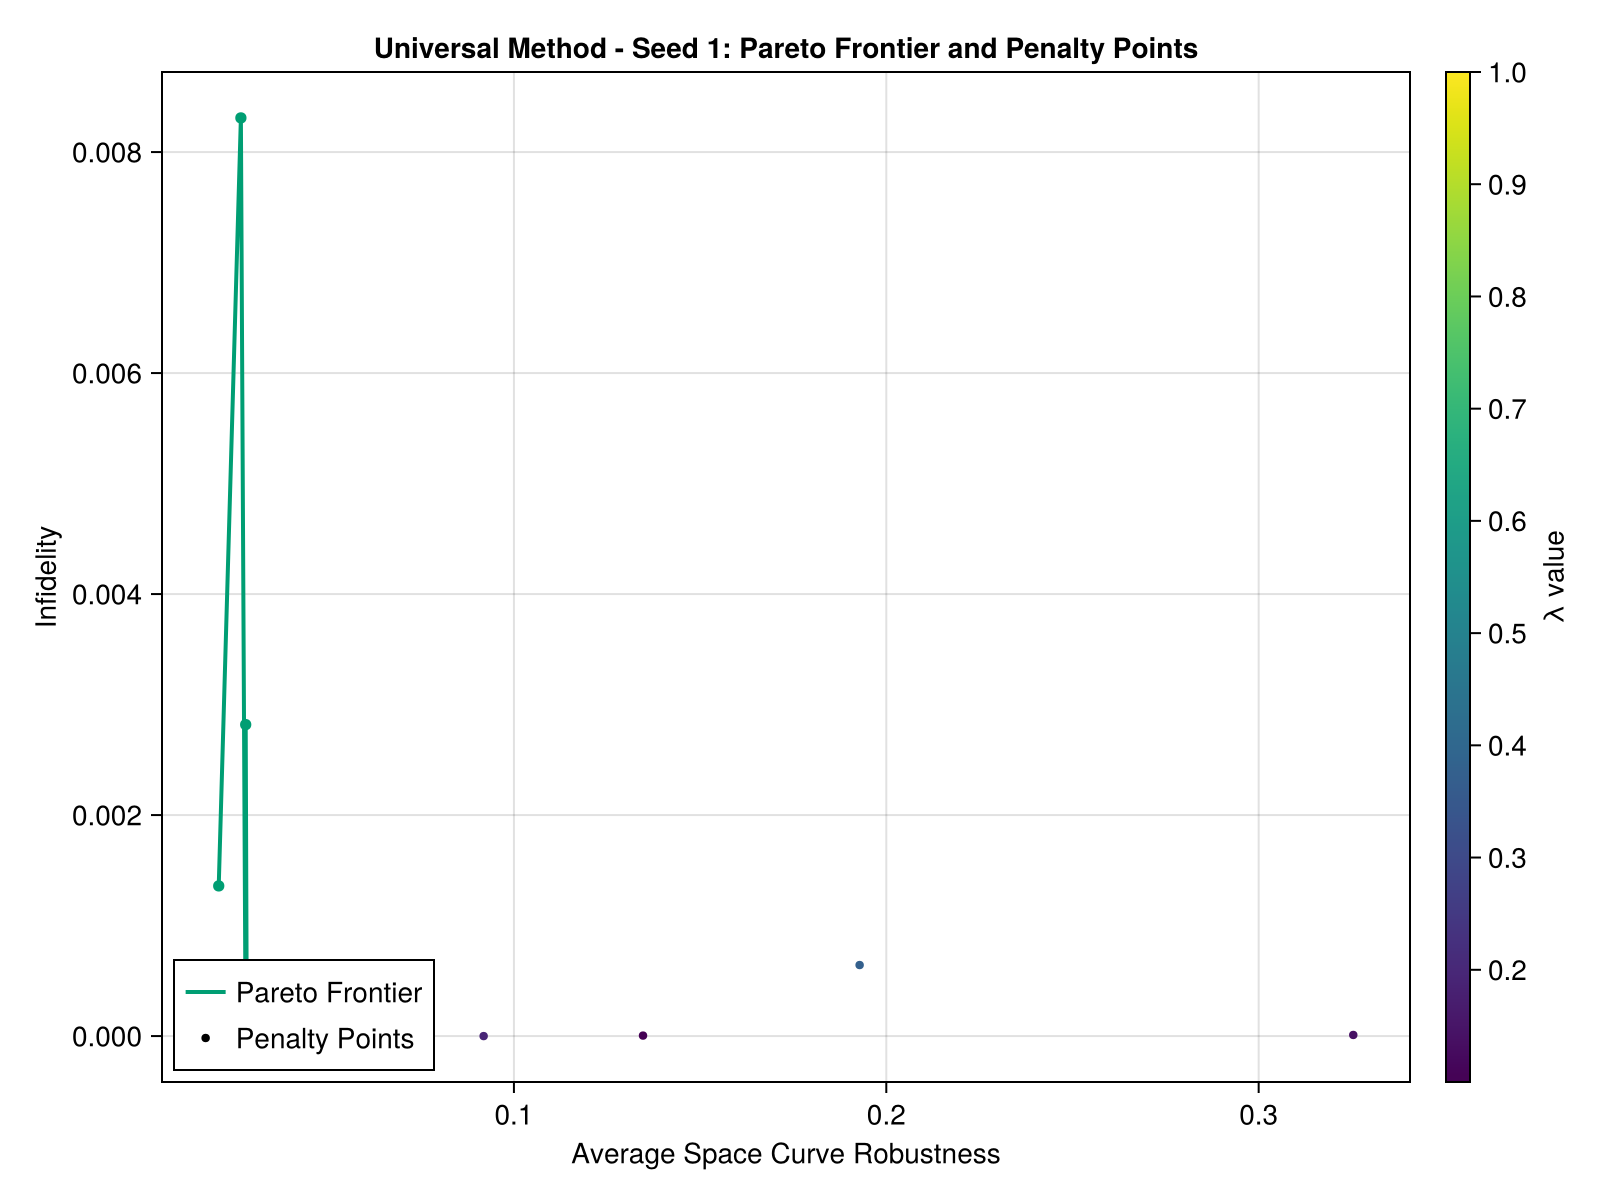

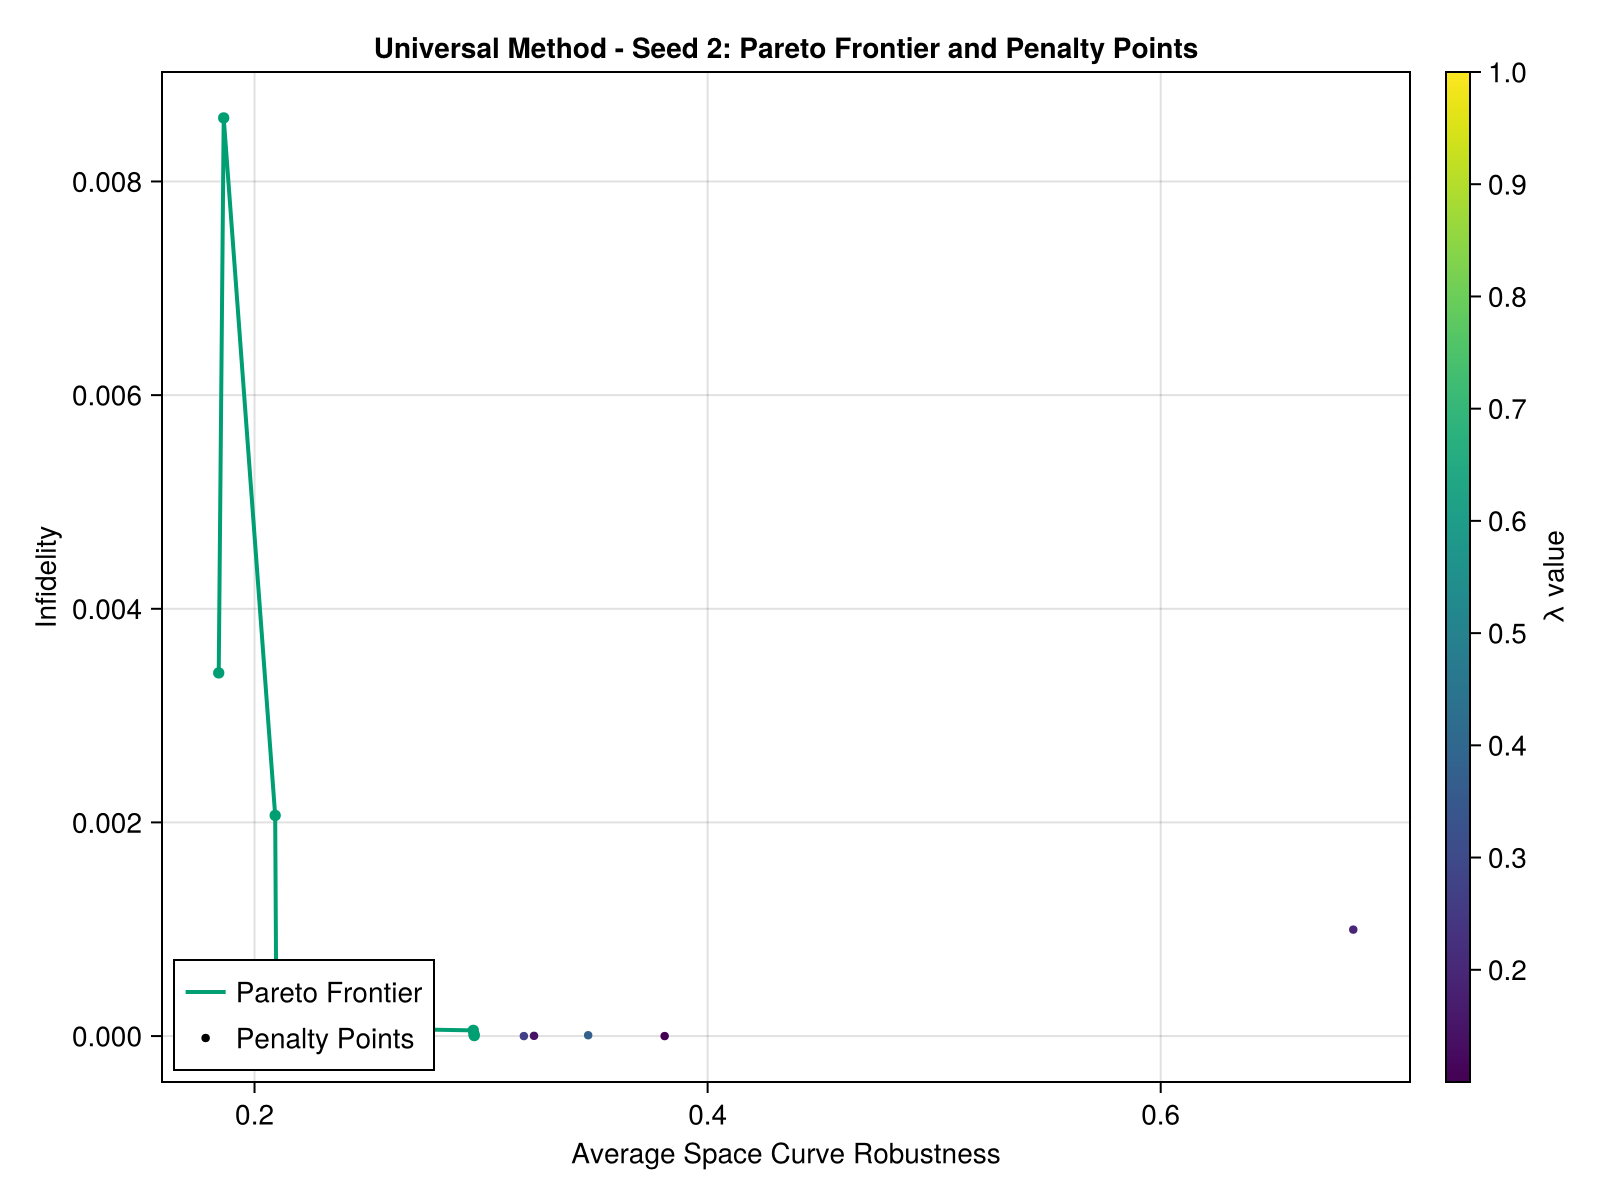

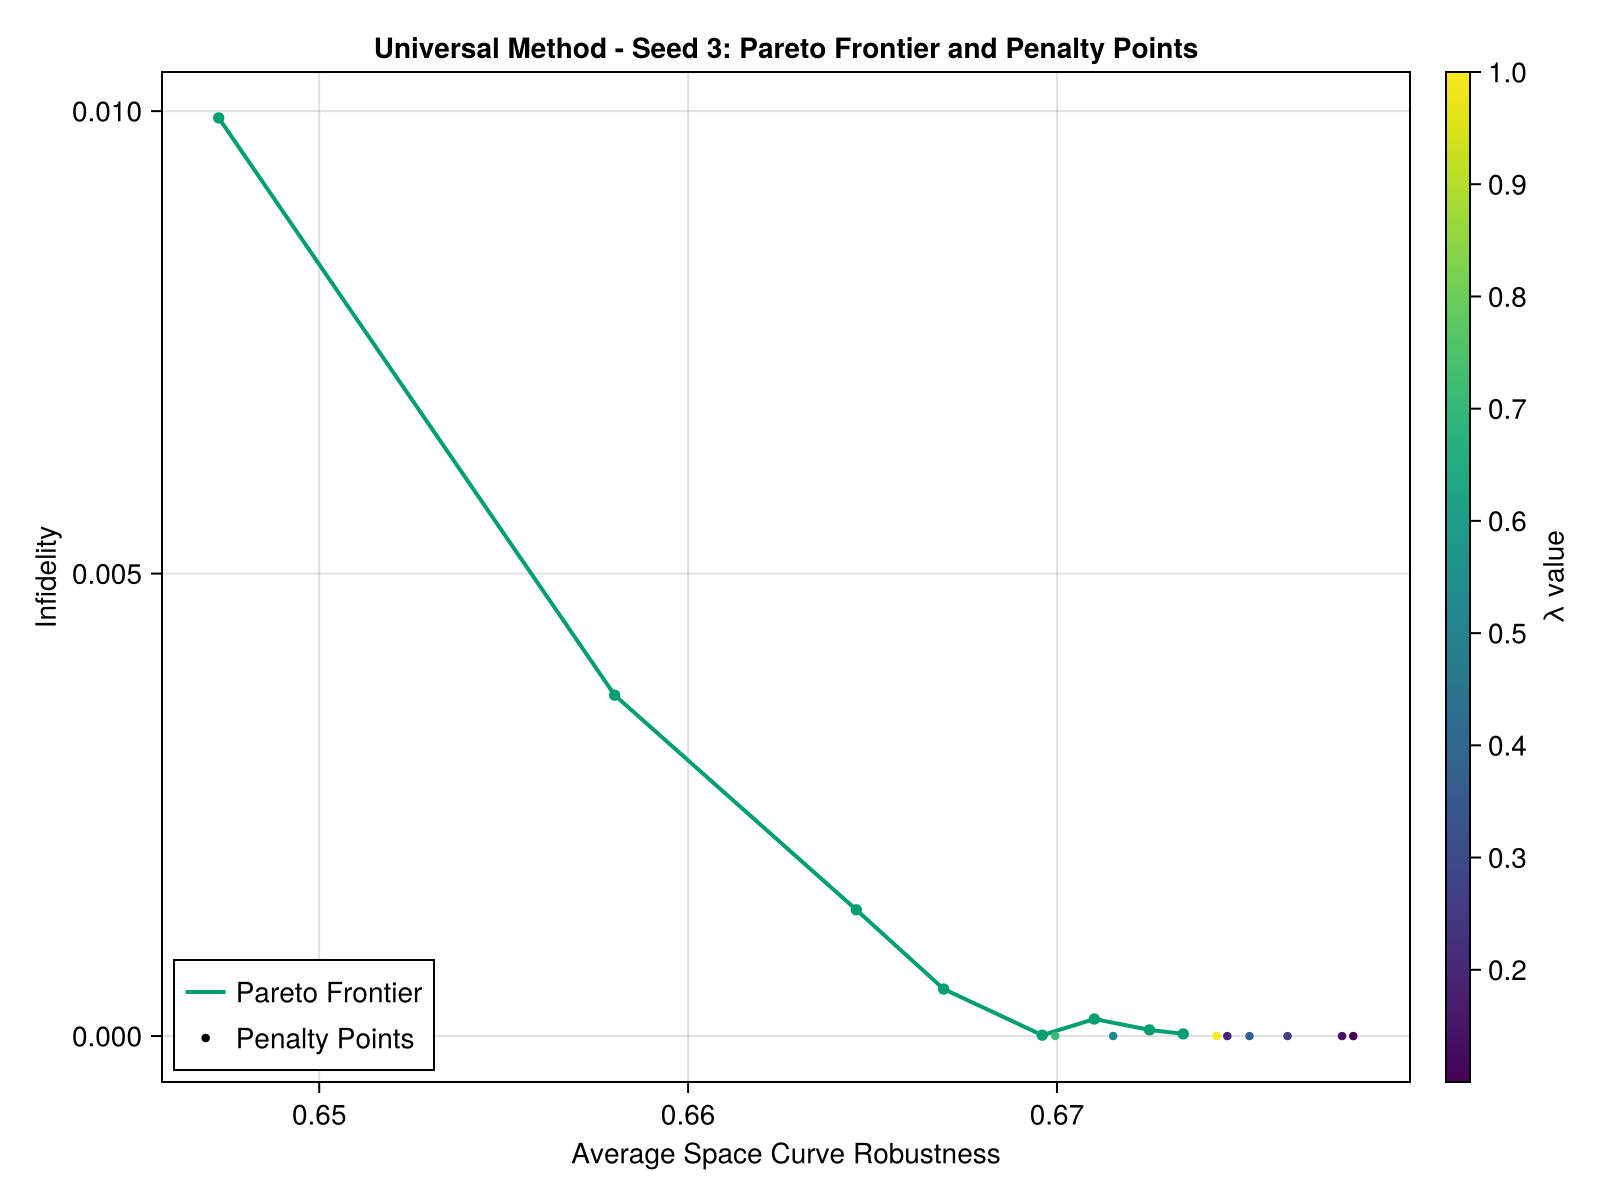

In [29]:
# Define colors for methods
# method_colors = [:blue, :red, :green]
colors = Makie.wong_colors()

method_names_plot = ["Variational", "Toggling", "Universal"]

for (method_idx, method_name) in enumerate(method_names_plot)
    println("Processing $method_name method...")
    
    # Get the appropriate problem arrays
    if method_idx == 1  # Variational
        pareto_probs = final_var_probs
        penalty_probs = pen_var_probs
    elseif method_idx == 2  # Toggling
        pareto_probs = final_tog_probs
        penalty_probs = pen_tog_probs
    else  # Universal
        pareto_probs = final_uni_probs
        penalty_probs = pen_uni_probs
    end
    
    # Create separate plot for each seed
    for s in 1:n_seeds
        fig = Figure(resolution=(800, 600))
        ax = Axis(fig[1, 1], 
                 xlabel="Average Space Curve Robustness", 
                 ylabel="Infidelity",
                 title="$method_name Method - Seed $s: Pareto Frontier and Penalty Points")
        
        # Pareto frontier points
        pareto_x = Float64[]
        pareto_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(pareto_x, avg_robustness)
            push!(pareto_y, 1-fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(pareto_x)
        lines!(ax, pareto_x[ord], pareto_y[ord], 
               color=colors[method_idx], linewidth=2, 
               label="Pareto Frontier")
        Makie.scatter!(ax, pareto_x[ord], pareto_y[ord], 
                color=colors[method_idx], markersize=8)
        
        # Penalty points
        penalty_x = Float64[]
        penalty_y = Float64[]
        lambda_vals = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(penalty_x, avg_robustness)
            push!(penalty_y, 1-fidelity)
            push!(lambda_vals, λ)
        end
        
        # Color penalty points by lambda value
        Makie.scatter!(ax, penalty_x, penalty_y, 
                color=lambda_vals, colormap=:viridis, markersize=6,
                label="Penalty Points")
        
        # Add colorbar for lambda values
        Colorbar(fig[1, 2], limits=(minimum(sweep_rob_loss_λ), maximum(sweep_rob_loss_λ)),
                 colormap=:viridis, label="λ value")
        
        axislegend(ax, position=:lb)
        display(fig)
    end
end

#### comparing pareto frontiers of objectives

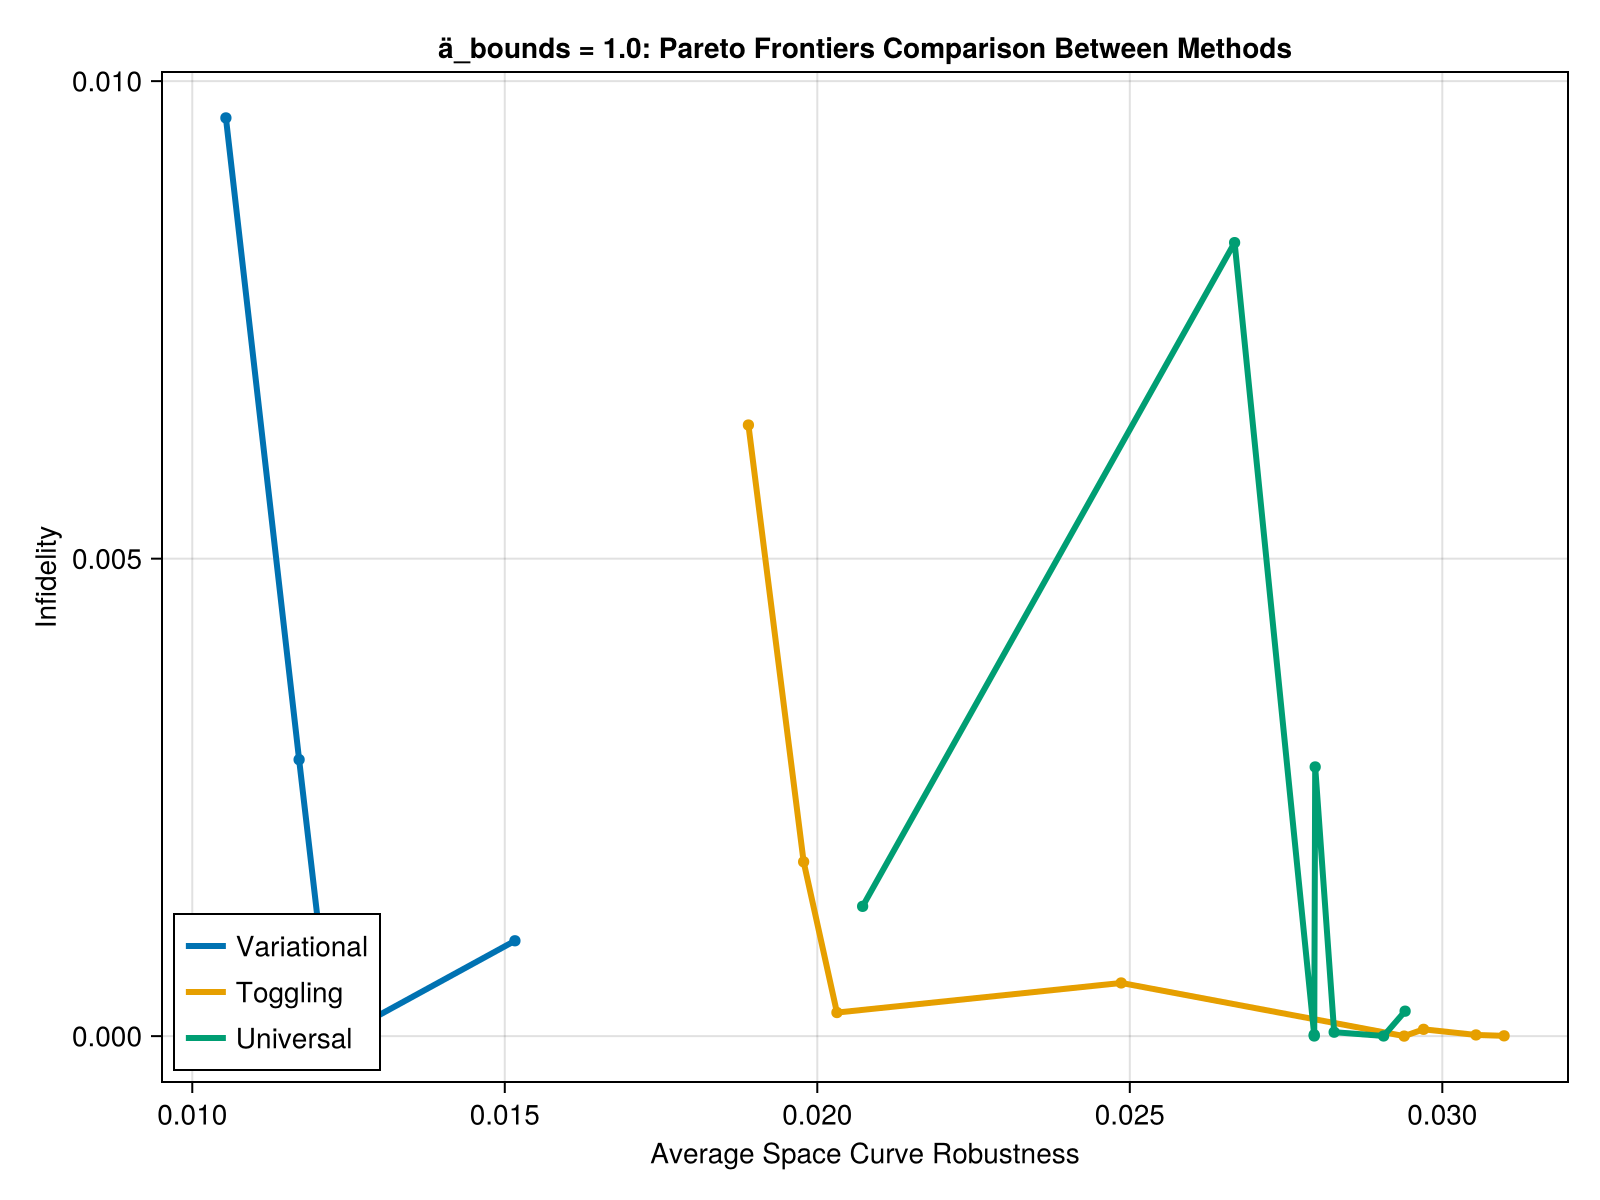

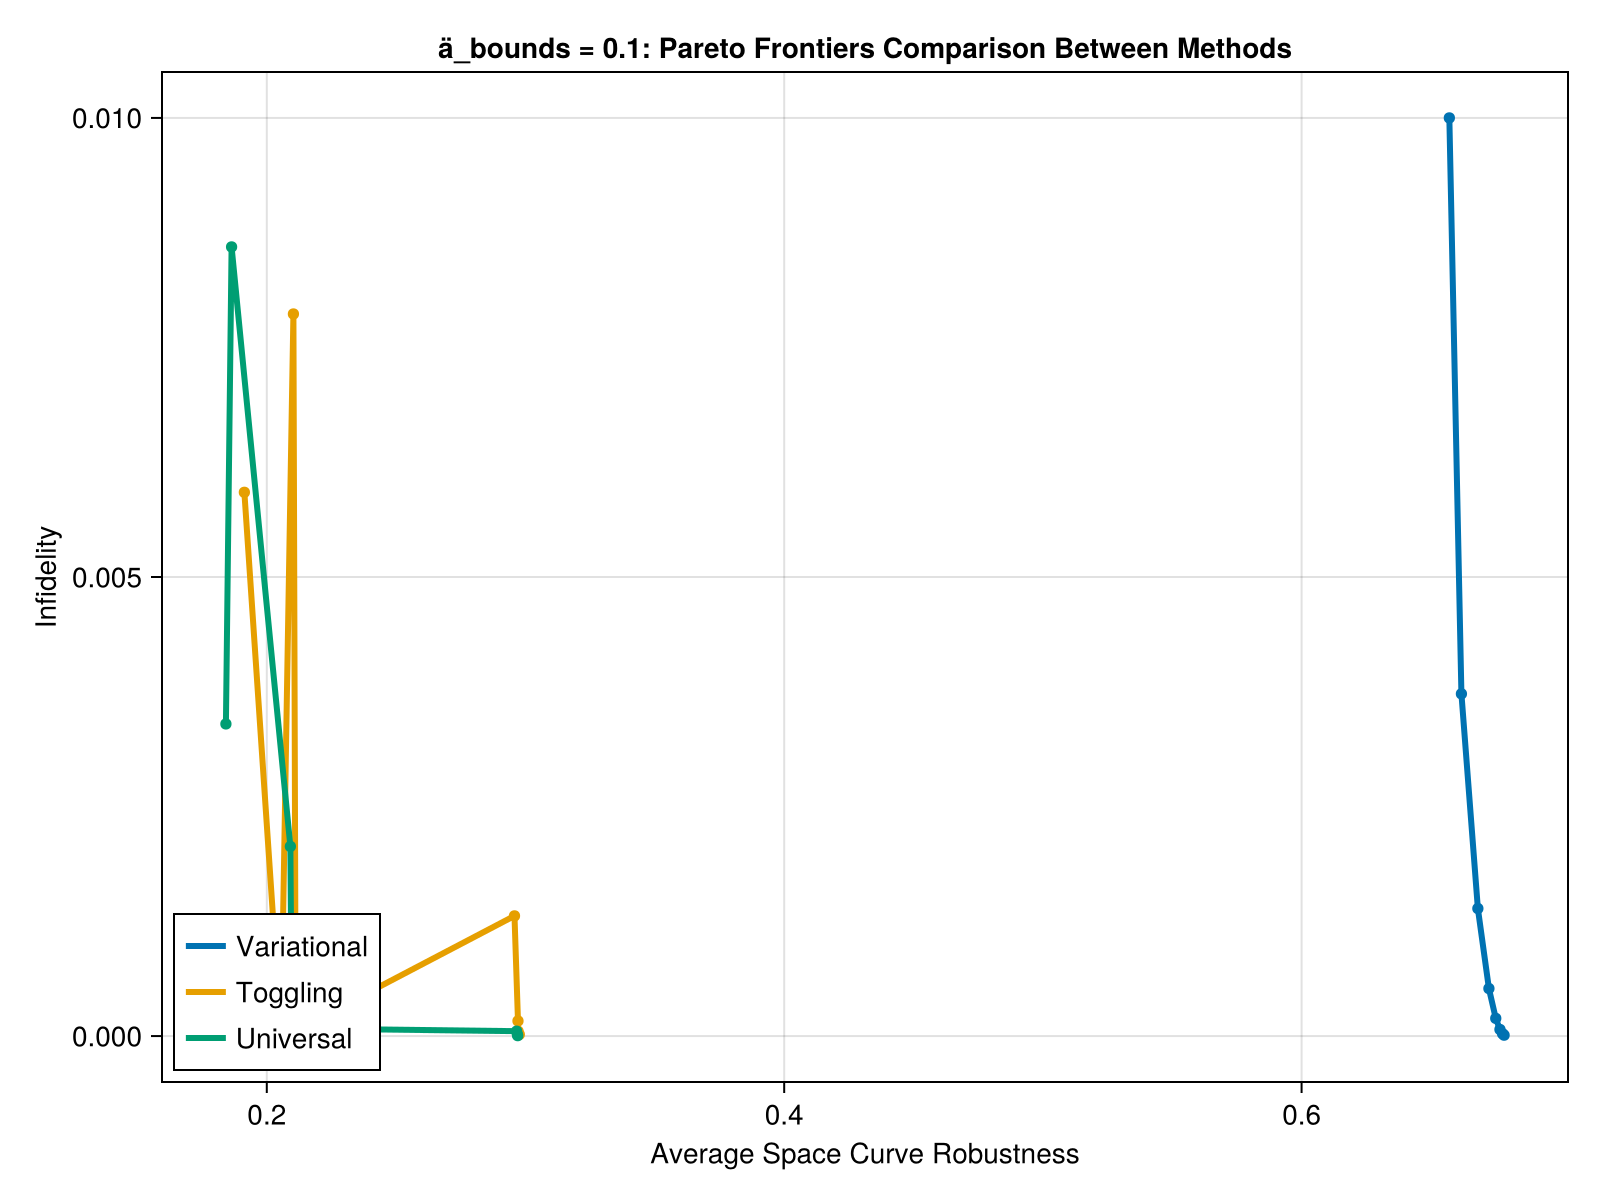

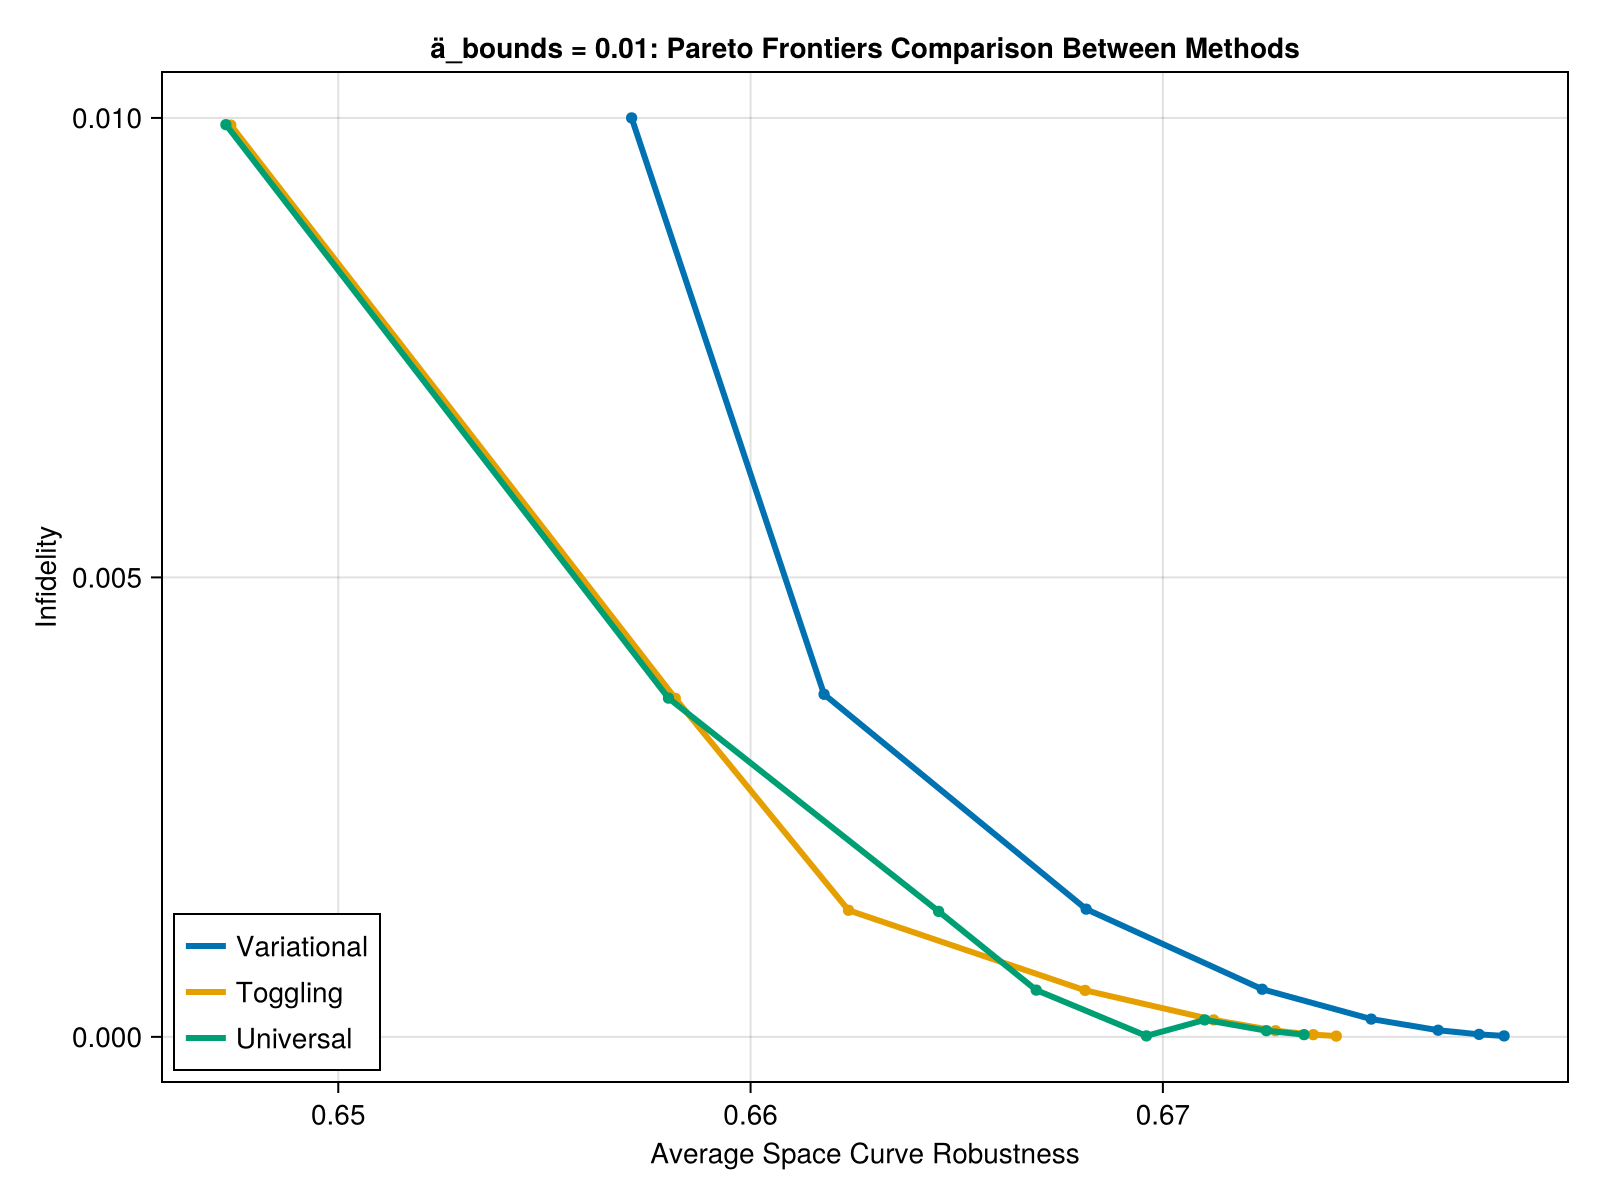

In [35]:
colors = Makie.wong_colors()

pareto_arrays = [final_var_probs, final_tog_probs, final_uni_probs]

# Create one plot for each seed
for s in 1:n_seeds
    fig = Figure(resolution=(800, 600))
    dda = round(10^(1.0-s); digits=2)
    ax = Axis(fig[1, 1], 
             xlabel="Average Space Curve Robustness", 
             ylabel="Infidelity",
             title="ä_bounds = $dda: Pareto Frontiers Comparison Between Methods")
    
    # Plot each method on this seed's plot
    for (method_idx, method_name) in enumerate(method_names_plot)
        pareto_probs = pareto_arrays[method_idx]
        
        # Collect points for this specific method and seed
        seed_x = Float64[]
        seed_y = Float64[]
        
        for j in 1:n_nines
            prob = pareto_probs[s, j]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            
            push!(seed_x, avg_robustness)
            push!(seed_y, 1-fidelity)
        end
        
        # Sort by x-axis for smooth line
        ord = sortperm(seed_x)
        lines!(ax, seed_x[ord], seed_y[ord], 
               color=colors[method_idx], linewidth=3, 
               label=method_name)
        Makie.scatter!(ax, seed_x[ord], seed_y[ord], 
                color=colors[method_idx], markersize=8)
    end
    
    axislegend(ax, position=:lb)
    display(fig)
end

### comparing penalty method performace of objective

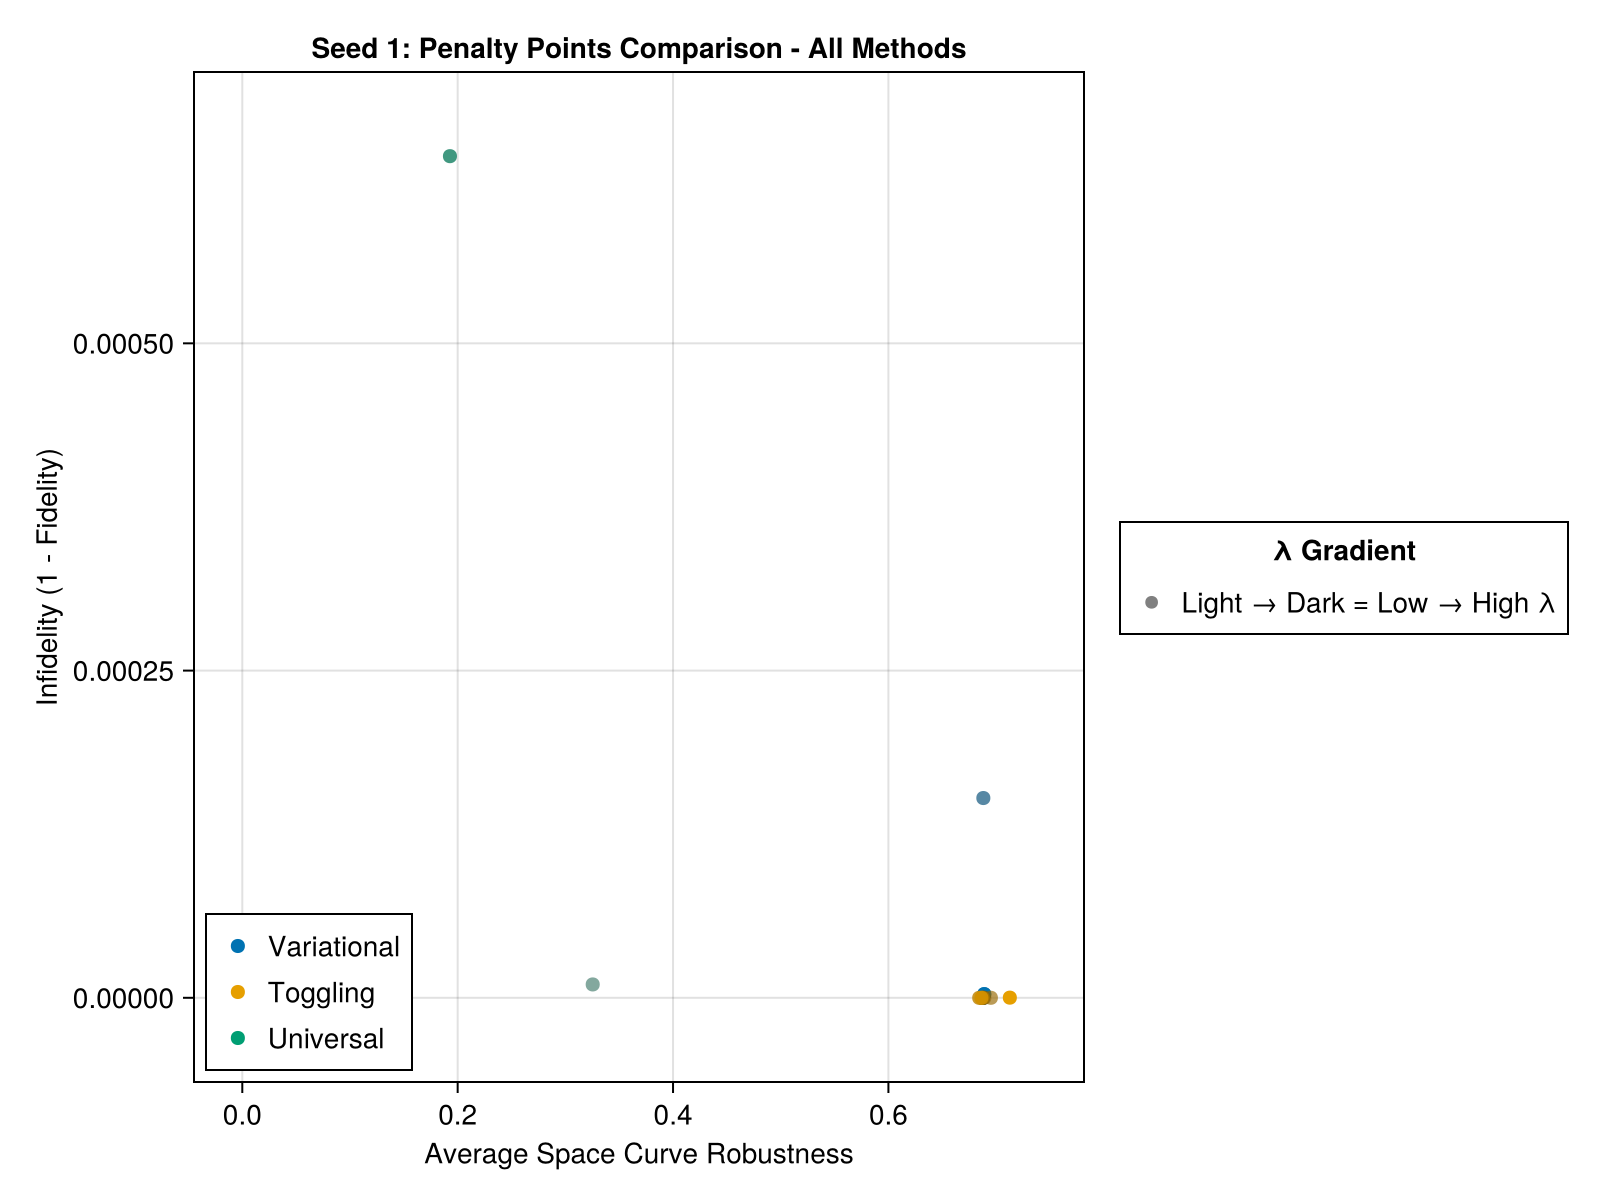

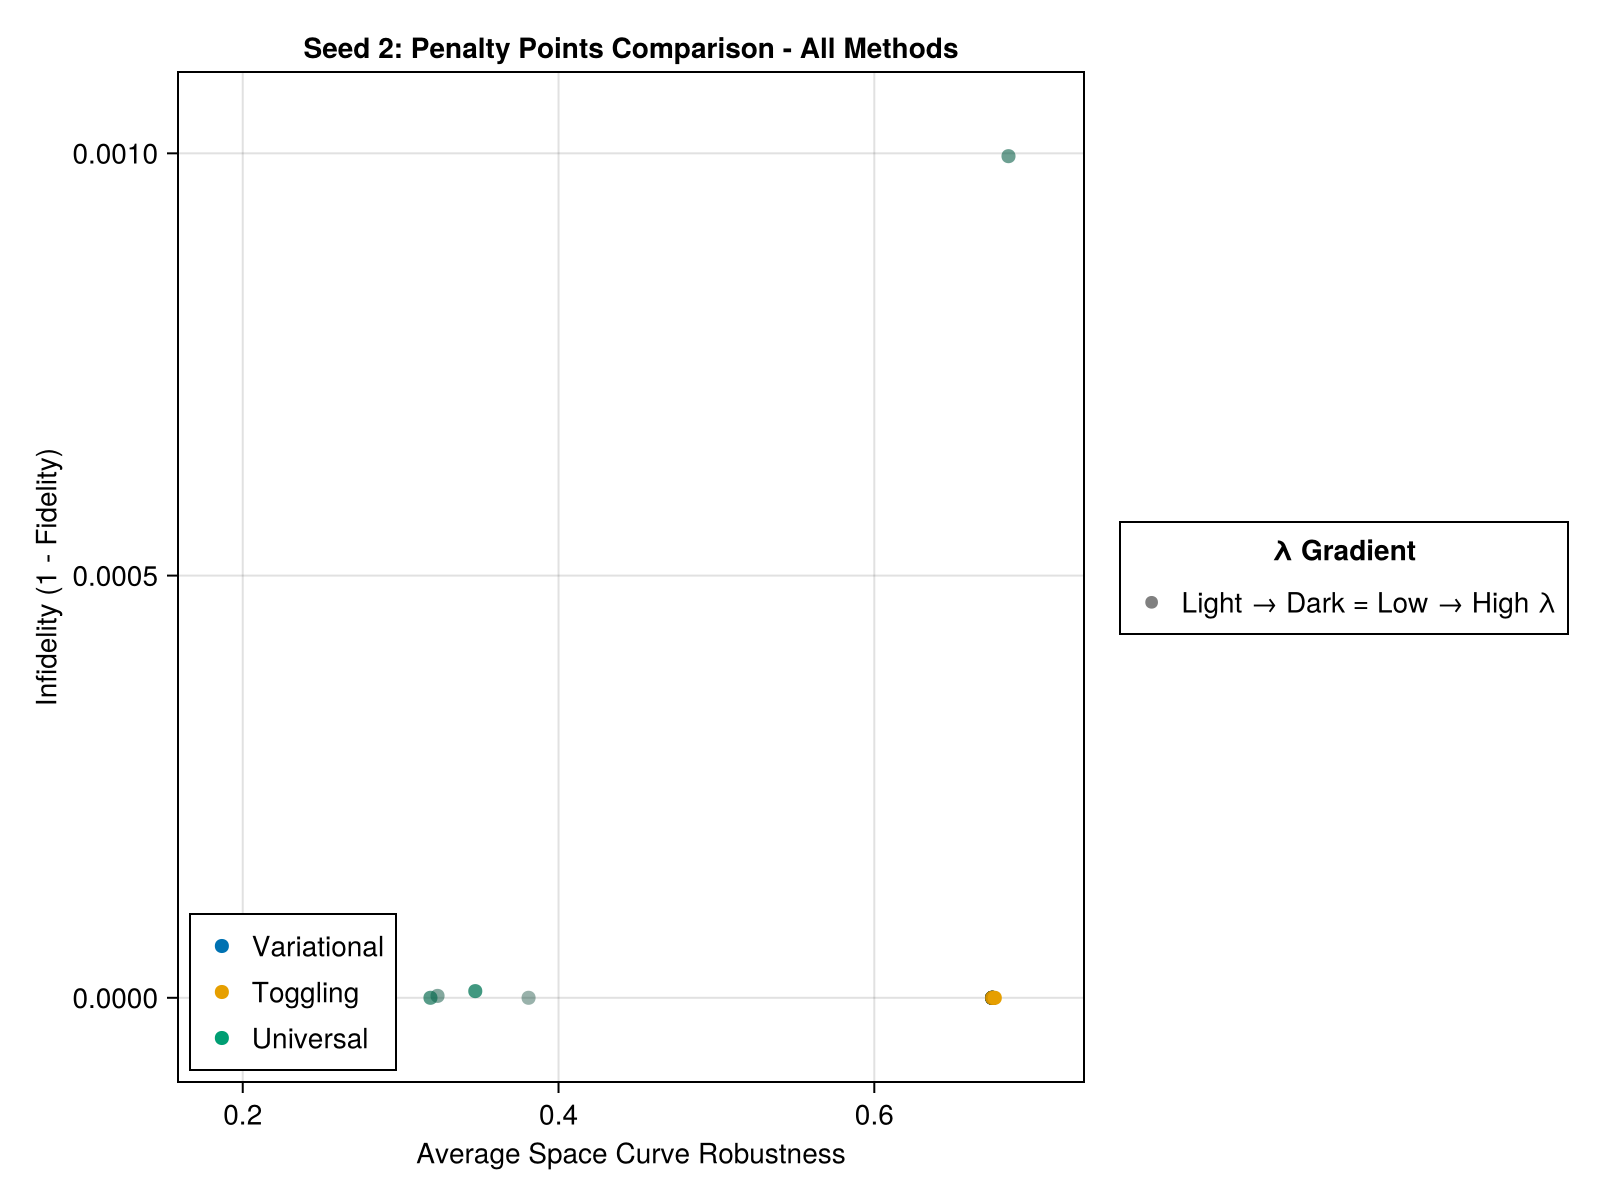

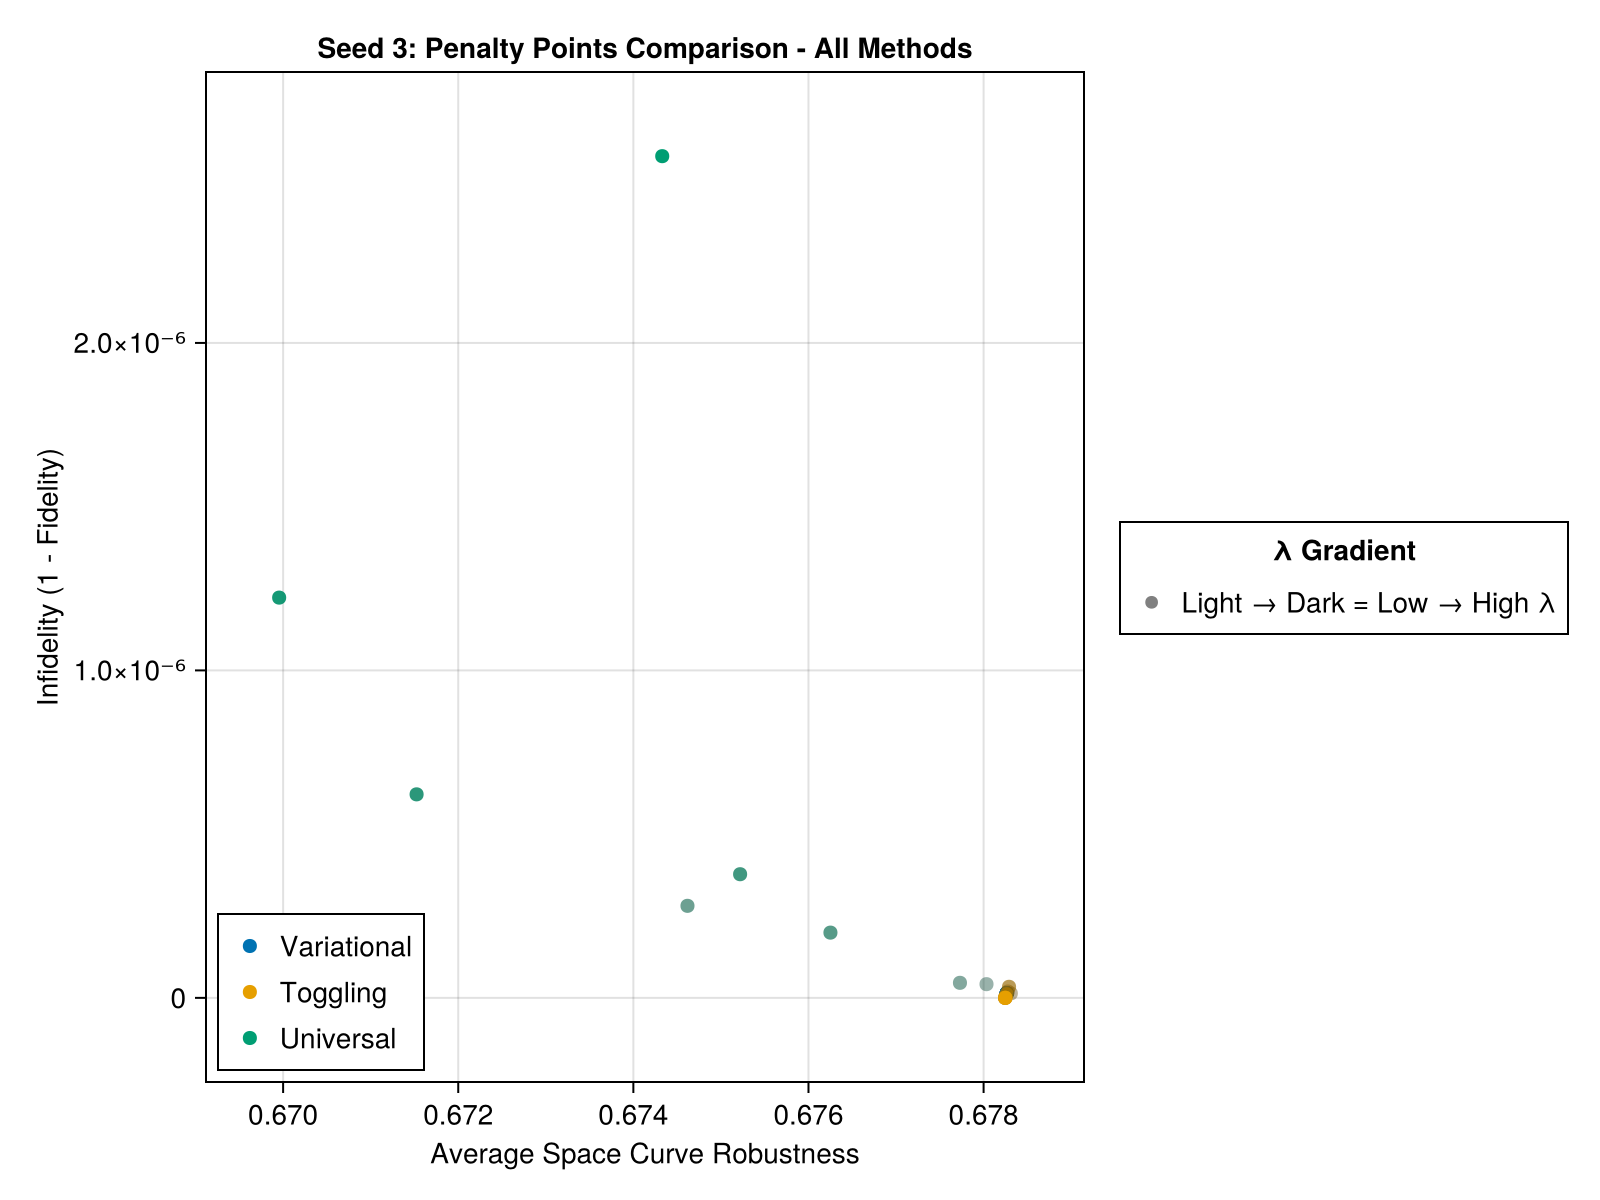

In [42]:
penalty_arrays = [pen_var_probs, pen_tog_probs, pen_uni_probs]
colors = Makie.wong_colors()

# Create one plot for each seed
for s in 1:n_seeds
    fig = Figure(resolution=(800, 600))
    ax = Axis(fig[1, 1], 
             xlabel="Average Space Curve Robustness", 
             ylabel="Infidelity (1 - Fidelity)",
             title="Seed $s: Penalty Points Comparison - All Methods")
    
    # Collect all points first to determine bounds
    all_x_points = Float64[]
    all_y_points = Float64[]
    
    # Plot each method on this seed's plot
    for (method_idx, method_name) in enumerate(method_names_plot)
        penalty_probs = penalty_arrays[method_idx]
        
        # Collect points for this specific method and seed across all lambdas
        seed_x = Float64[]
        seed_y = Float64[]
        seed_lambda = Float64[]
        
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = penalty_probs[s, λ_idx]
            X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
            Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
            Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
            avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
            fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
            infidelity = 1 - fidelity  # Convert to infidelity
            
            push!(seed_x, avg_robustness)
            push!(seed_y, infidelity)
            push!(seed_lambda, λ)
            
            # Collect for bounds calculation
            push!(all_x_points, avg_robustness)
            push!(all_y_points, infidelity)
        end
        
        # Sort by lambda for consistent coloring
        lambda_order = sortperm(seed_lambda)
        
        # Create gradient from light to dark for this method's base color
        base_color = colors[method_idx]
        n_points = length(seed_lambda)
        
        # Create array of colors with varying intensity (0.4 to 1.0)
        intensities = range(0.4, 1.0, length=n_points)
        point_colors = [base_color * intensity for intensity in intensities]
        
        Makie.scatter!(ax, seed_x[lambda_order], seed_y[lambda_order], 
                color=point_colors, markersize=10)
        
        # Add a representative point for the legend with the base color
        Makie.scatter!(ax, Float64[], Float64[], 
                color=base_color, markersize=10, label=method_name)
    end
    
    # Set axis limits based on data distribution (with some padding)
    x_range = maximum(all_x_points) - minimum(all_x_points)
    y_range = maximum(all_y_points) - minimum(all_y_points)
    
    Makie.xlims!(ax, minimum(all_x_points) - 0.1*x_range, maximum(all_x_points) + 0.1*x_range)
    Makie.ylims!(ax, minimum(all_y_points) - 0.1*y_range, maximum(all_y_points) + 0.1*y_range)
    
    # Create custom legend showing lambda gradient
    Legend(fig[1, 2], 
           [MarkerElement(color=:gray, marker=:circle)],
           ["Light → Dark = Low → High λ"],
           "λ Gradient")
    
    axislegend(ax, position=:lb)
    display(fig)
end

println("All plots completed!")

# Optional: Save plots
# save("penalty_seed_$s.png", fig)

In [43]:
# Summary statistics
println("\nSummary Statistics:")
println("==================")

for (method_idx, method_name) in enumerate(method_names_plot)
    println("\n$method_name Method:")
    
    if method_idx == 1
        probs = final_var_probs
    elseif method_idx == 2
        probs = final_tog_probs
    else
        probs = final_uni_probs
    end
    
    robustness_vals = Float64[]
    fidelity_vals = Float64[]
    
    for s in 1:n_seeds, j in 1:n_nines
        prob = probs[s, j]
        X_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.X)
        Y_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Y)
        Z_robustness = space_curve_robustness(prob.trajectory, U_goal, PAULIS.Z)
        avg_robustness = (X_robustness + Y_robustness + Z_robustness) / 3
        fidelity = unitary_rollout_fidelity(prob.trajectory, sys)
        
        push!(robustness_vals, avg_robustness)
        push!(fidelity_vals, fidelity)
    end
    
    println("  Robustness range: $(round(minimum(robustness_vals), digits=6)) - $(round(maximum(robustness_vals), digits=6))")
    println("  Fidelity range: $(round(minimum(fidelity_vals), digits=6)) - $(round(maximum(fidelity_vals), digits=6))")
    println("  Mean robustness: $(round(mean(robustness_vals), digits=6))")
    println("  Mean fidelity: $(round(mean(fidelity_vals), digits=6))")
end

### Save trajectories 

In [45]:
using JLD2
using Dates
n_lambdas = length(sweep_rob_loss_λ)
# Collect trajectories only (lighter than storing whole problem objects)
default_trajs    = [default_probs[i, j].trajectory    for i in 1:n_seeds, j in 1:n_nines]
final_var_probs  = [final_var_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
final_tog_probs  = [final_tog_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_nines]
final_uni_probs = [final_uni_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_nines]
pen_var_probs  = [pen_var_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_lambdas]
pen_tog_probs  = [pen_tog_probs[i, j].trajectory  for i in 1:n_seeds, j in 1:n_lambdas]
pen_uni_probs = [pen_uni_probs[i, j].trajectory for i in 1:n_seeds, j in 1:n_lambdas]

# # Optional: fidelity traces you computed
# fid_traces = Dict(
#     "init_def_fids"  => init_def_fids,
#     "init_add_fids"  => init_add_fids,
#     "init_mult_fids" => init_mult_fids,
# )

# Minimal metadata to reconstruct the setup
arr_dda_bounds = [fill(10^(1.0-i), n_drives) for i in 1:3]

meta = Dict(
    "T" => T,
    "Δt" => Δt,
    "U_goal" => U_goal,
    "n_seeds" => n_seeds,
    "n_nines" => n_nines,
    "n_lambdas" => n_lambdas,
    "final_fid_floor" => final_fid_floor,
    "dda_bounds" => arr_dda_bounds,
    "n_drives" => n_drives,
)

# Make an artifacts/ folder and generate a timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "trajectories_$(timestamp).jld2")

@info "Saving trajectories to $outfile"
@save outfile default_trajs final_var_probs final_tog_probs final_uni_probs pen_var_probs pen_tog_probs pen_uni_probs meta
@info "Done. Saved keys: default_trajs, final_var_probs, final_tog_probs, final_uni_probs, pen_var_probs, pen_tog_probs, pen_uni_probs, meta"


To load the data for later, use:

In [23]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs, final_var_probs, final_tog_probs, final_uni_probs, pen_var_probs, pen_tog_probs, pen_uni_probs, meta
